<a href="https://colab.research.google.com/github/r-kovalch/acter-ner/blob/main/notebooks/acter-heuristics-multilingual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/r-kovalch/acter-ner

Cloning into 'acter-ner'...
remote: Enumerating objects: 566, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 566 (delta 37), reused 6 (delta 5), pack-reused 491 (from 1)
Receiving objects: 100% (566/566), 4.98 MiB | 19.47 MiB/s, done.
Resolving deltas: 100% (363/363), done.


In [3]:
!git clone https://github.com/r-kovalch/extractomat.git && cd extractomat/ && git checkout acter && cd ..
#!git clone https://github.com/lang-uk/extractomat.git

Cloning into 'extractomat'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 52 (delta 25), reused 42 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 54.46 KiB | 18.15 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Branch 'acter' set up to track remote branch 'acter' from 'origin'.
Switched to a new branch 'acter'


In [4]:
!git clone https://github.com/AylaRT/ACTER

Cloning into 'ACTER'...
remote: Enumerating objects: 5448, done.
remote: Counting objects: 100% (5448/5448), done.
remote: Compressing objects: 100% (3304/3304), done.
remote: Total 5448 (delta 2684), reused 4893 (delta 2132), pack-reused 0 (from 0)
Receiving objects: 100% (5448/5448), 11.90 MiB | 15.88 MiB/s, done.
Resolving deltas: 100% (2684/2684), done.


In [5]:
!pip install -q \
  numpy==1.26.4 \
  spacy \
  spacy-layout \
  sentence-transformers \
  gitpython \
  matplotlib \
  tqdm -q

!python -m spacy download en_core_web_sm
!python -m spacy download nl_core_news_sm
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 118.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), "extractomat"))

import subprocess, sys
from pathlib import Path
from extractomat.matcha import cvalue
import spacy

import numpy as np
import matplotlib.pyplot as plt
from extractomat.tester import TermEvaluator

from extractomat.sbert_reranker import SentenceSimilarityCalculator
import torch

from extractomat.matcha import UPOS_TO_PENN

In [2]:
C_VALUE_MIN_TERMS = 2
C_VALUE_MAX_TERMS = 4
C_VALUE_SMOOTHING = 0.1

In [28]:
root_folder = "content"

language_input_dirs: dict[str, list[str]] = {
    "en": [
        f"/{root_folder}/ACTER/en/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/en/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/en/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/en/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    ],
    "fr": [
        f"/{root_folder}/ACTER/fr/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/fr/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/fr/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/fr/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    ],
    "nl": [
        f"/{root_folder}/ACTER/nl/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/nl/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/nl/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/nl/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    ]
}
language_output_dirs: dict[str, dict[str, str]] = {
    "en": {
        "train": f"/{root_folder}/en/train_full.tsv",
        "val":   f"/{root_folder}/en/val_full.tsv",
        "test":  f"/{root_folder}/en/dummy_test.tsv",
    },
    "fr": {
        "train": f"/{root_folder}/fr/train_full.tsv",
        "val":   f"/{root_folder}/fr/val_full.tsv",
        "test":  f"/{root_folder}/fr/dummy_test.tsv",
    },
    "nl": {
        "train": f"/{root_folder}/nl/train_full.tsv",
        "val":   f"/{root_folder}/nl/val_full.tsv",
        "test":  f"/{root_folder}/nl/dummy_test.tsv",
    }
}

languages = list(language_input_dirs.keys())

for language in languages:
    io_dirs = language_input_dirs[language]
    train_tsv = Path(language_output_dirs[language]["train"])
    test_tsv  = Path(language_output_dirs[language]["test"])
    val_tsv   = Path(language_output_dirs[language]["val"])

    language_args = [
        "python",
        f"/{root_folder}/acter-ner/term_extractor/preprocess_acter.py",
        "--input_dirs", *io_dirs,
        "--train_output", str(train_tsv),
        "--test_output",  str(test_tsv),
        "--val_output",   str(val_tsv),
        "--test_size", "0.005",
        "--val_size",  "0.195",
        "--seed",      "42",
    ]
    print("⏳ Running:", language)
    subprocess.check_call(language_args)
    print("✅ Splits ready ", train_tsv, ",", val_tsv, ", and", test_tsv)


⏳ Running: en
0
✅ Splits ready  /content/en/train_full.tsv , /content/en/val_full.tsv , and /content/en/dummy_test.tsv
⏳ Running: fr
0
✅ Splits ready  /content/fr/train_full.tsv , /content/fr/val_full.tsv , and /content/fr/dummy_test.tsv
⏳ Running: nl
0
✅ Splits ready  /content/nl/train_full.tsv , /content/nl/val_full.tsv , and /content/nl/dummy_test.tsv


In [4]:
language_nlp_models: dict[str, str] = {
    "en": "en_core_web_sm",
    "fr": "fr_core_news_sm",
    "nl": "nl_core_news_sm"
}

for lang, model in language_nlp_models.items():
    # load spacy
    nlp = spacy.load(model, disable=["ner","parser"])
    nlp.max_length = 1_500_000

    # read the test-split text
    txt_file = Path(language_output_dirs[lang]["test"]).with_suffix("").joinpath("text.txt")
    doc      = nlp(txt_file.read_text())

    # collect all UPOS tags in the doc
    used_upos = {token.pos_ for token in doc}

    # compute unmapped
    mapped_upos   = set(UPOS_TO_PENN.keys())
    unmapped_upos = used_upos - mapped_upos

    print(f"{lang.upper()}: used UPOS = {sorted(used_upos)}")
    print(f"{lang.upper()}: unmapped = {sorted(unmapped_upos)}\n")

    # assert none are left over
    assert not unmapped_upos, (
        f"❌ Found unmapped UPOS in {lang}: {sorted(unmapped_upos)}"
    )

print("✅ All UPOS tags are covered in EN, FR and NL.")


EN: used UPOS = ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'SYM', 'VERB', 'X']
EN: unmapped = []

FR: used UPOS = ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'SYM', 'VERB']
FR: unmapped = []

NL: used UPOS = ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'SYM', 'VERB', 'X']
NL: unmapped = []

✅ All UPOS tags are covered in EN, FR and NL.


In [5]:
c_value_results: dict[str, dict] = {
    "en": {
        "train": {},
        "val":   {},
        "test":  {}
    },
    "fr": {
        "train": {},
        "val":   {},
        "test":  {},
    },
    "nl": {
        "train": {},
        "val":   {},
        "test":  {},
    },
}

for language in languages:
    nlp = spacy.load(language_nlp_models[language], disable=["ner"])
    nlp.max_length = 1500000

    for subset in c_value_results[language].keys():
        subset_tsv = Path(language_output_dirs[language][subset])
        doc = nlp(Path(os.path.join(subset_tsv.with_suffix(''), "text.txt")).read_text().lower())

        term_scores, term_occ = cvalue(
            doc,
            n_min=C_VALUE_MIN_TERMS,
            n_max=C_VALUE_MAX_TERMS,
            smoothing=C_VALUE_SMOOTHING,
        )

        c_value_results[language][subset] = {
            "term_scores": term_scores,
            "term_occ":    term_occ
        }

        print(f"Extracted {len(term_scores):,} candidate terms for {subset} for {language}")


Extracted 21,816 candidate terms for train for en
Extracted 6,379 candidate terms for val for en
Extracted 205 candidate terms for test for en
Extracted 8,985 candidate terms for train for fr
Extracted 2,707 candidate terms for val for fr
Extracted 98 candidate terms for test for fr
Extracted 12,339 candidate terms for train for nl
Extracted 3,402 candidate terms for val for nl
Extracted 98 candidate terms for test for nl


EN train:  P=0.289  R=0.142  F1=0.190
EN val  :  P=0.138  R=0.623  F1=0.225
EN test :  P=0.171  R=0.512  F1=0.256
FR train:  P=0.134  R=0.065  F1=0.087
FR val  :  P=0.067  R=0.197  F1=0.100
FR test :  P=0.197  R=0.273  F1=0.229
NL train:  P=0.109  R=0.172  F1=0.133
NL val  :  P=0.077  R=0.475  F1=0.132
NL test :  P=0.114  R=0.529  F1=0.187


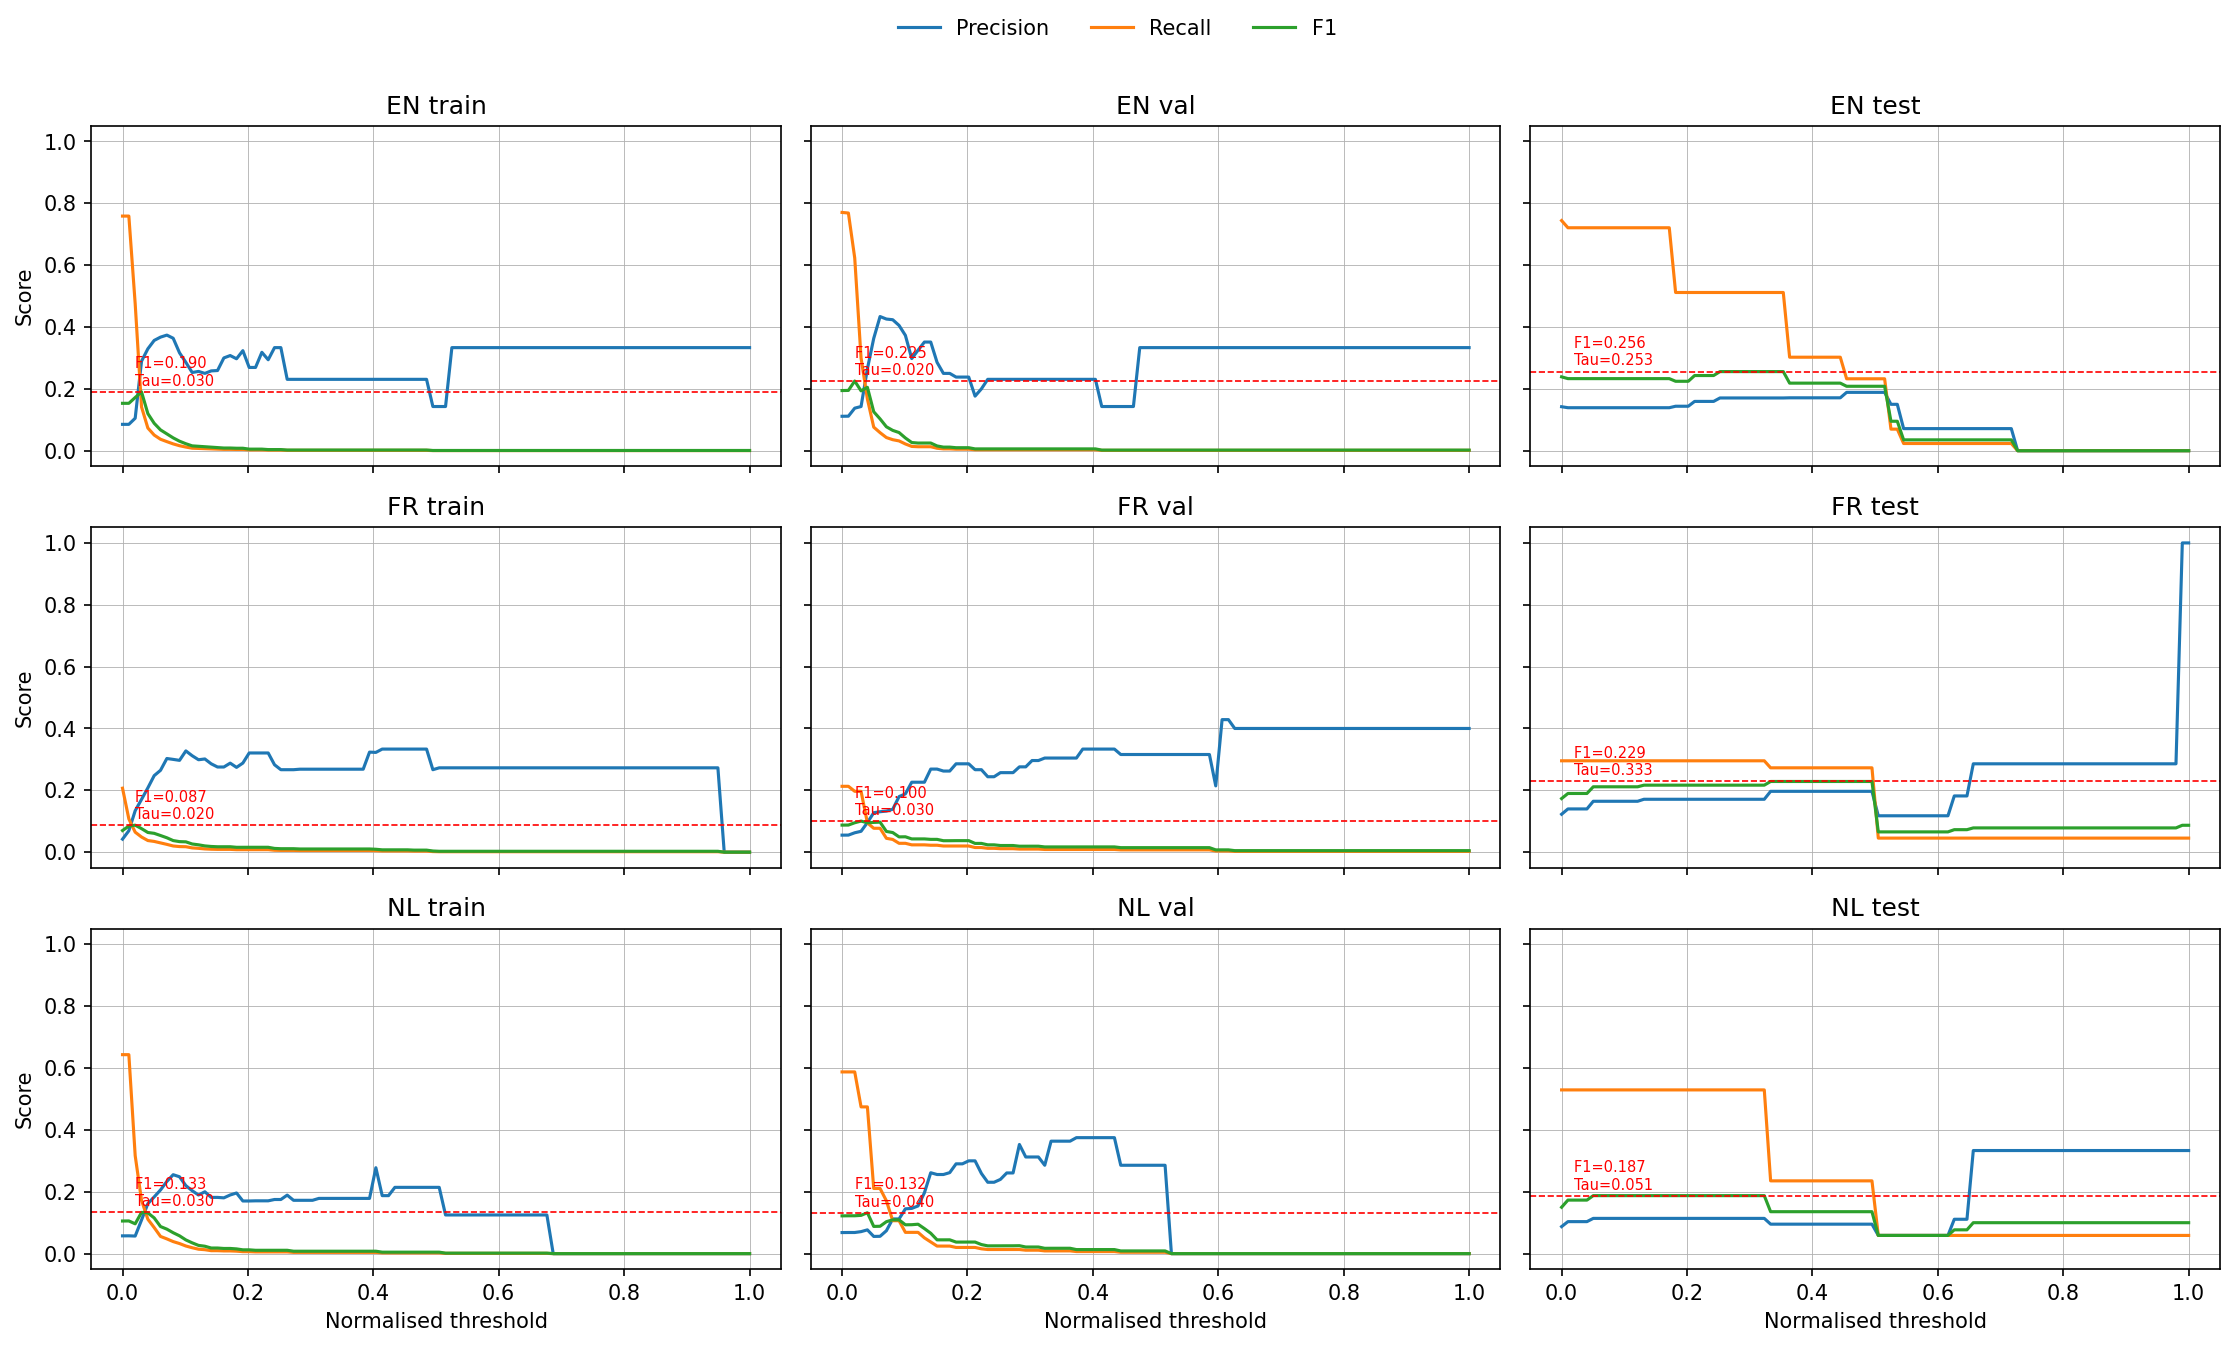

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from extractomat.tester import TermEvaluator

languages = list(c_value_results.keys())
splits    = list(next(iter(c_value_results.values())).keys())

fig, axes = plt.subplots(len(languages), len(splits),
                         figsize=(15, 9), dpi=150,
                         sharex=True, sharey=True)

for r, lang in enumerate(languages):
    for c, split in enumerate(splits):
        ax   = axes[r, c]
        data = c_value_results[lang][split]
        if not data:
            ax.axis("off"); continue

        gt_csv = (Path(language_output_dirs[lang][split])
                  .with_suffix("").joinpath("gt_labels.csv"))
        ev = TermEvaluator(gt_csv,
                           data["term_scores"],
                           data["term_occ"],
                           method="cvalue",
                           language=lang)

        scores   = np.fromiter(data["term_scores"].values(), float)
        lo, hi   = scores.min(), scores.max()
        abs_thr  = np.linspace(lo - 1e-9, hi, 100)
        norm_thr = (abs_thr - lo) / (hi - lo)

        P = np.zeros_like(abs_thr)
        R = np.zeros_like(abs_thr)
        F = np.zeros_like(abs_thr)

        for i, t in enumerate(abs_thr):
            try:
                P[i], R[i], F[i] = ev.calculate_metrics(t)
            except ZeroDivisionError:
                pass

        ax.plot(norm_thr, P, label="Precision")
        ax.plot(norm_thr, R, label="Recall")
        ax.plot(norm_thr, F, label="F1")

        best = np.argmax(F)
        ax.axhline(F[best], color="red", ls="--", lw=.8)
        ax.text(0.02, F[best] + 0.02,
                f"F1={F[best]:.3f} \nTau={norm_thr[best]:.3f}", color="red", fontsize=7)

        if r == len(languages) - 1: ax.set_xlabel("Normalised threshold")
        if c == 0:                   ax.set_ylabel("Score")
        ax.set_title(f"{lang.upper()} {split}")
        ax.grid(True, lw=.4)

        print(f"{lang.upper()} {split:5}:  "
              f"P={P[best]:.3f}  R={R[best]:.3f}  F1={F[best]:.3f}")

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
reranker = SentenceSimilarityCalculator(
    model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    device=device
)

rerank_results = {lang: {} for lang in c_value_results}

for language, splits in c_value_results.items():
    nlp = spacy.load(language_nlp_models[language], disable=["ner"])
    nlp.max_length = 1500000

    for subset, cv_data in splits.items():
        subset_tsv = Path(language_output_dirs[language][subset])
        doc = nlp(Path(os.path.join(subset_tsv.with_suffix(''), "text.txt")).read_text().lower())

        reranked = reranker.rerank_terms_in_doc(
            doc,
            cv_data["term_occ"],
            context_len=3,
            pooling="max"
        )
        rerank_results[language][subset] = reranked

        print(f"[Rerank] {language} {subset}: {len(reranked):,} terms")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[Rerank] en train: 21,816 terms
[Rerank] en val: 6,379 terms
[Rerank] en test: 205 terms
[Rerank] fr train: 8,985 terms
[Rerank] fr val: 2,707 terms
[Rerank] fr test: 98 terms
[Rerank] nl train: 12,339 terms
[Rerank] nl val: 3,402 terms
[Rerank] nl test: 98 terms


[Rerank] EN train:  P=0.134  R=0.382  F1=0.198
[Rerank] EN val  :  P=0.155  R=0.445  F1=0.230
[Rerank] EN test :  P=0.173  R=0.512  F1=0.259
[Rerank] FR train:  P=0.066  R=0.089  F1=0.075
[Rerank] FR val  :  P=0.087  R=0.096  F1=0.091
[Rerank] FR test :  P=0.129  R=0.295  F1=0.179
[Rerank] NL train:  P=0.071  R=0.349  F1=0.118
[Rerank] NL val  :  P=0.071  R=0.497  F1=0.125
[Rerank] NL test :  P=0.110  R=0.529  F1=0.182


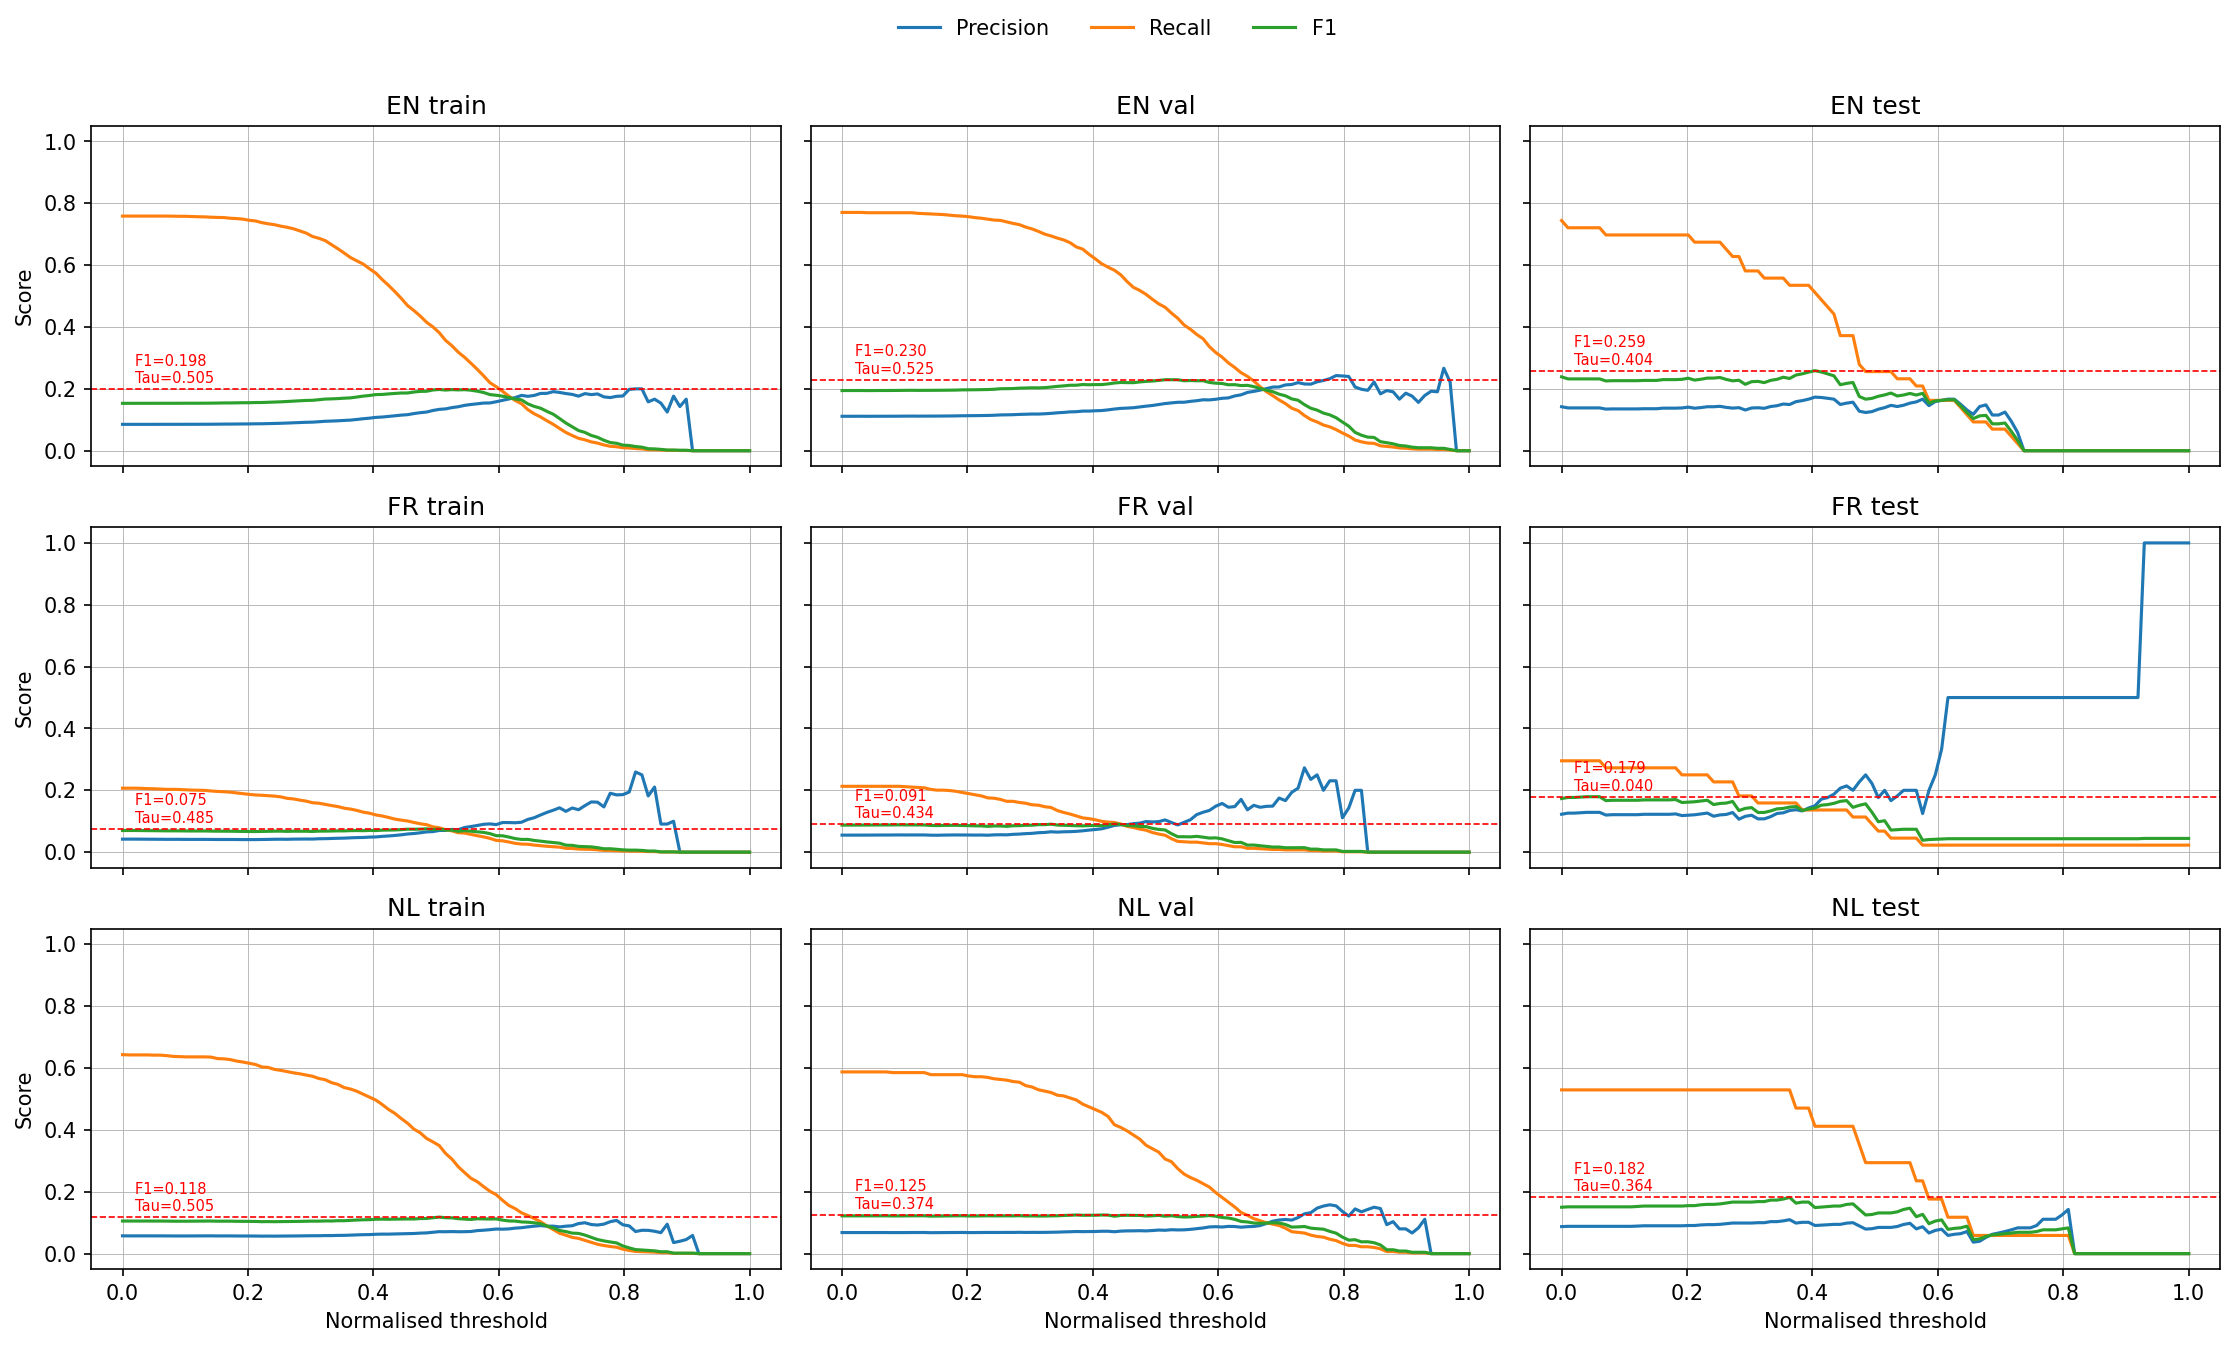

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from extractomat.tester import TermEvaluator

# assume rerank_results has the same structure as c_value_results:
#   rerank_results[lang][split] → dict(term → score)
# and term_occ still lives in c_value_results for each lang/split

languages = list(rerank_results.keys())
splits    = list(next(iter(rerank_results.values())).keys())

fig, axes = plt.subplots(len(languages), len(splits),
                         figsize=(15, 9), dpi=150,
                         sharex=True, sharey=True)

for r, lang in enumerate(languages):
    for c, split in enumerate(splits):
        ax    = axes[r, c]
        scores = rerank_results[lang][split]
        occ    = c_value_results[lang][split]["term_occ"]

        if not scores or not occ:
            ax.axis("off")
            continue

        gt_csv = (Path(language_output_dirs[lang][split])
                  .with_suffix("").joinpath("gt_labels.csv"))
        ev = TermEvaluator(gt_csv,
                           scores,
                           occ,
                           method="rerank",    # or still "cvalue" if metrics are the same
                           language=lang)

        arr = np.fromiter(scores.values(), float)
        lo, hi   = arr.min(), arr.max()
        abs_thr  = np.linspace(lo - 1e-9, hi, 100)
        norm_thr = (abs_thr - lo) / (hi - lo)

        P = np.zeros_like(abs_thr)
        R = np.zeros_like(abs_thr)
        F = np.zeros_like(abs_thr)

        for i, t in enumerate(abs_thr):
            try:
                P[i], R[i], F[i] = ev.calculate_metrics(t)
            except ZeroDivisionError:
                pass

        ax.plot(norm_thr, P, label="Precision")
        ax.plot(norm_thr, R, label="Recall")
        ax.plot(norm_thr, F, label="F1")

        best = np.argmax(F)
        ax.axhline(F[best], color="red", ls="--", lw=.8)
        ax.text(0.02, F[best] + 0.02,
                f"F1={F[best]:.3f} \nTau={norm_thr[best]:.3f}", color="red", fontsize=7)

        if r == len(languages) - 1:
            ax.set_xlabel("Normalised threshold")
        if c == 0:
            ax.set_ylabel("Score")

        ax.set_title(f"{lang.upper()} {split}")
        ax.grid(True, lw=.4)

        print(f"[Rerank] {lang.upper()} {split:5}:  "
              f"P={P[best]:.3f}  R={R[best]:.3f}  F1={F[best]:.3f}")

# shared legend
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


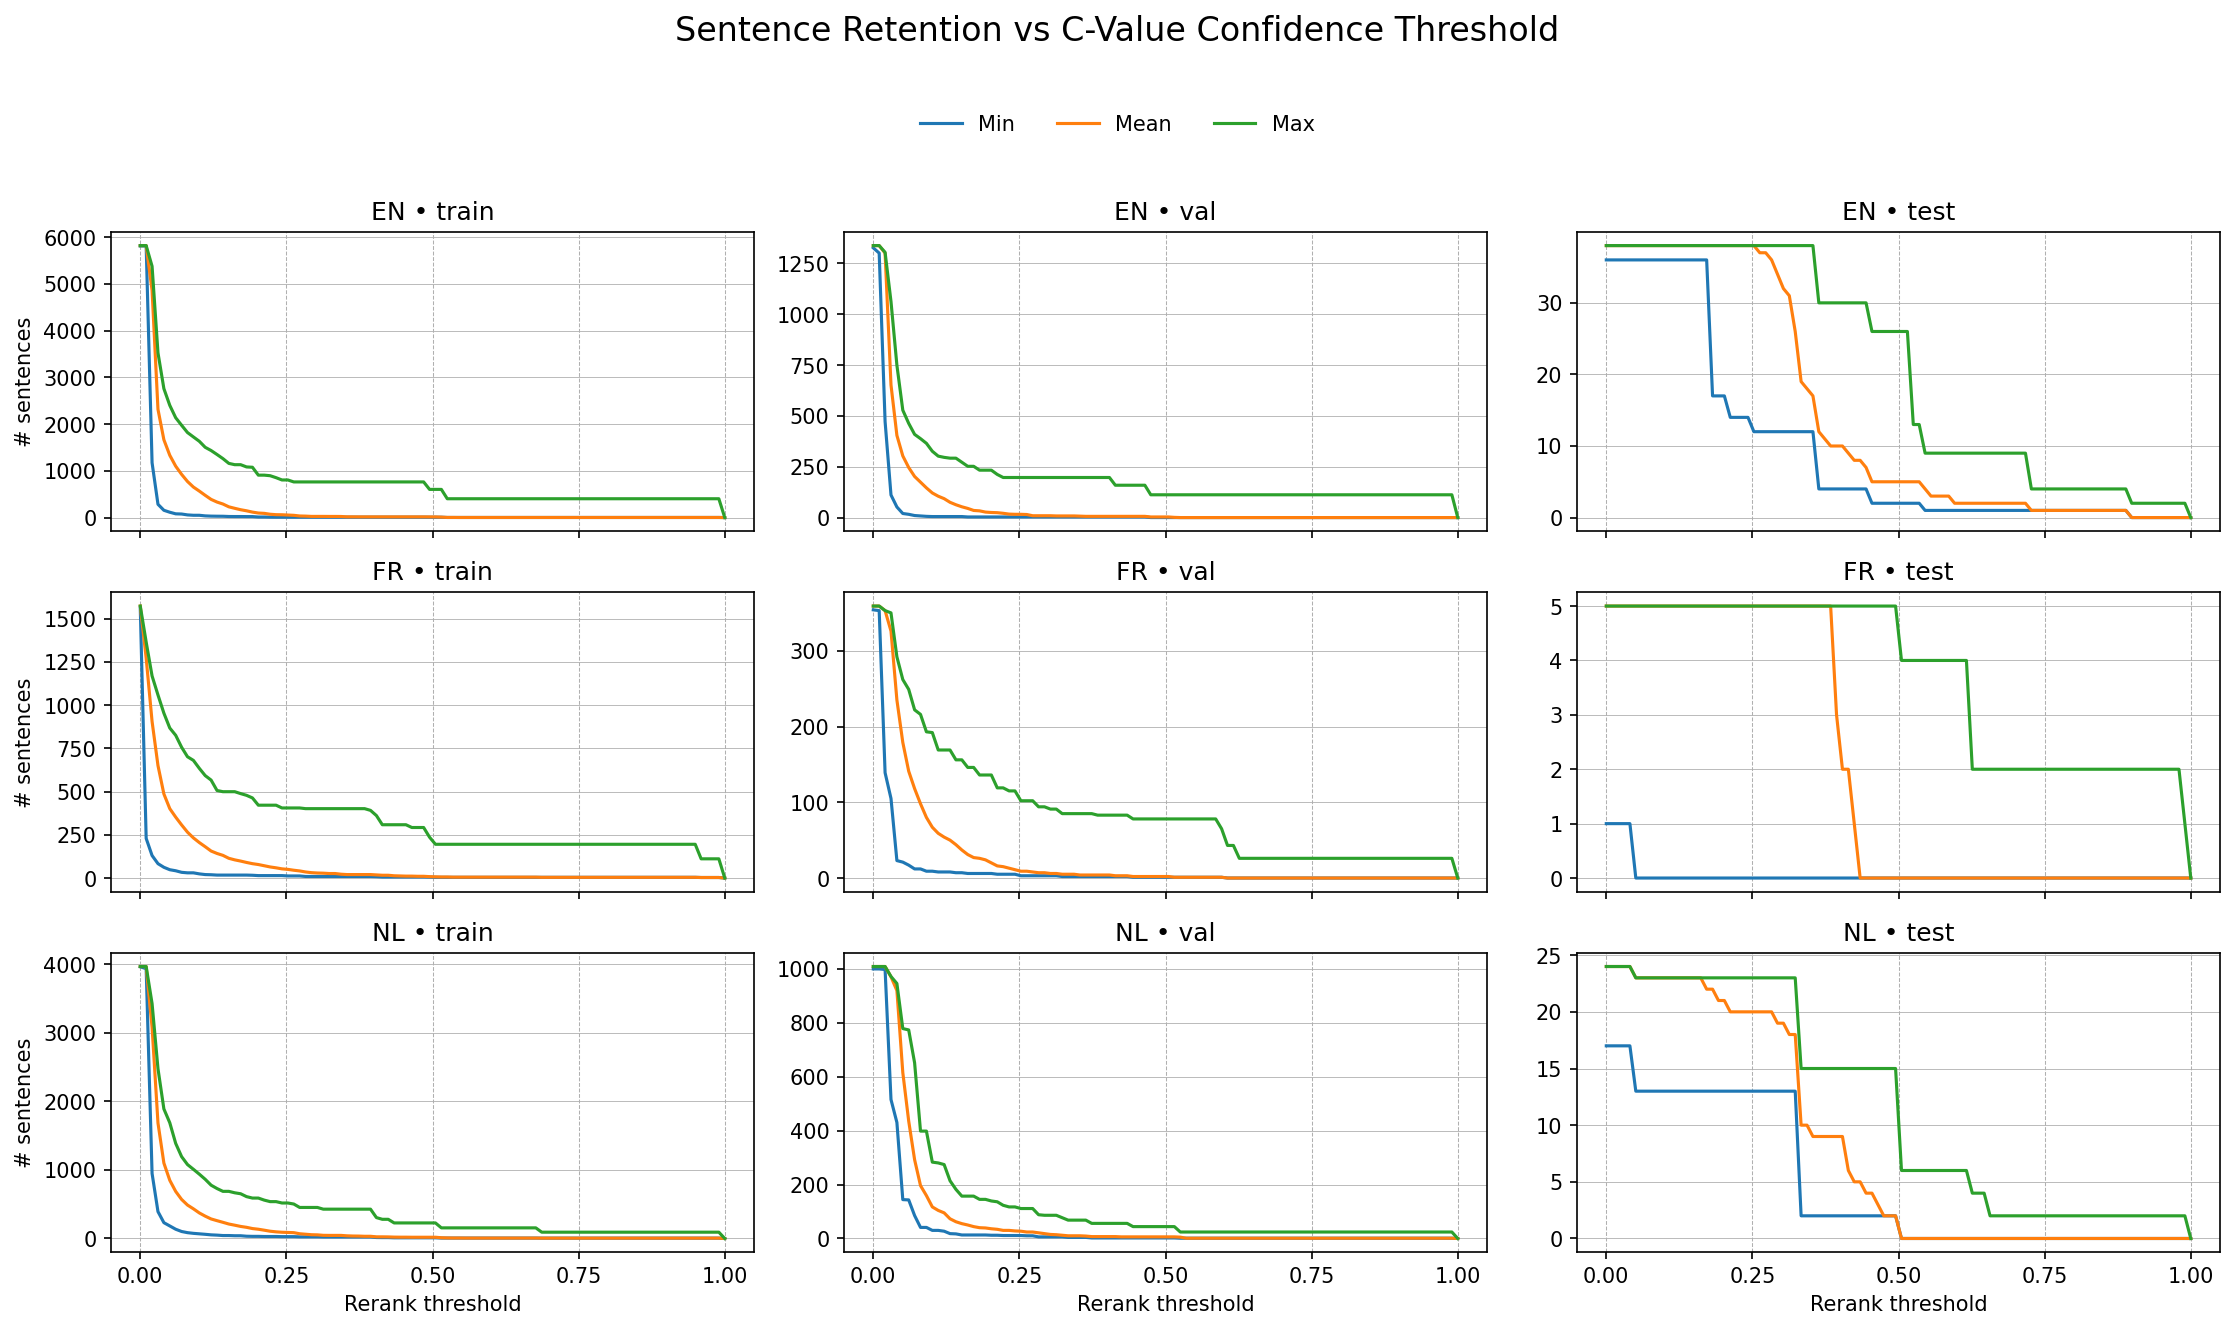

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from extractomat.tester import TermEvaluator

languages = list(rerank_results.keys())
splits    = list(next(iter(rerank_results.values())).keys())

fig, axes = plt.subplots(len(languages), len(splits),
                         figsize=(15, 9), dpi=150,
                         sharex=True, sharey=False)

for i, lang in enumerate(languages):
    for j, split in enumerate(splits):
        ax        = axes[i, j]
        c_scores  = c_value_results[lang][split]["term_scores"]
        term_occ  = c_value_results[lang][split]["term_occ"]

        if not c_scores or not term_occ:
            ax.axis("off")
            continue

        # bucket rerank scores by sentence
        bucket_r = defaultdict(list)
        for term, spans in term_occ.items():
            score = c_scores.get(term)
            if score is None: continue
            for span in spans:
                bucket_r[span.sent].append(score)

        # compute per-sentence stats
        mins, means, maxs = [], [], []
        for scores in bucket_r.values():
            mins.append(min(scores))
            means.append(np.mean(scores))
            maxs.append(max(scores))
        mins  = np.array(mins)
        means = np.array(means)
        maxs  = np.array(maxs)

        # threshold range
        thr = np.linspace(mins.min(), maxs.max(), 100)
        norm_thr = (thr - mins.min()) / (maxs.max() - mins.min())

        # count sentences above each threshold
        cnt_min  = [(mins  > t).sum() for t in thr]
        cnt_mean = [(means > t).sum() for t in thr]
        cnt_max  = [(maxs  > t).sum() for t in thr]

        # plot curves
        ax.plot(norm_thr, cnt_min,  label="Min")
        ax.plot(norm_thr, cnt_mean, label="Mean")
        ax.plot(norm_thr, cnt_max,  label="Max")

        # calculate 5% padding
        x0, x1 = norm_thr.min(), norm_thr.max()
        y0, y1 = 0, max(cnt_min + cnt_mean + cnt_max)
        x_pad  = 0.05 * (x1 - x0)
        y_pad  = 0.05 * (y1 - y0)

        # apply padding
        ax.set_xlim(x0 - x_pad, x1 + x_pad)
        ax.set_ylim(y0 - y_pad, y1 + y_pad)

        # set ticks and grids
        ax.set_xticks(np.linspace(x0, x1, 5))
        ax.grid(axis="x", linestyle="--", linewidth=0.5)
        ax.grid(axis="y", linewidth=0.4)

        # labels and titles
        if i == len(languages) - 1:
            ax.set_xlabel("Rerank threshold")
        if j == 0:
            ax.set_ylabel("# sentences")
        ax.set_title(f"{lang.upper()} • {split}")

# overall title and legend
fig.suptitle("Sentence Retention vs С-Value Confidence Threshold", fontsize=16)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
            loc="upper center",
            bbox_to_anchor=(0.5, 0.92),
            ncol=3,
            frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


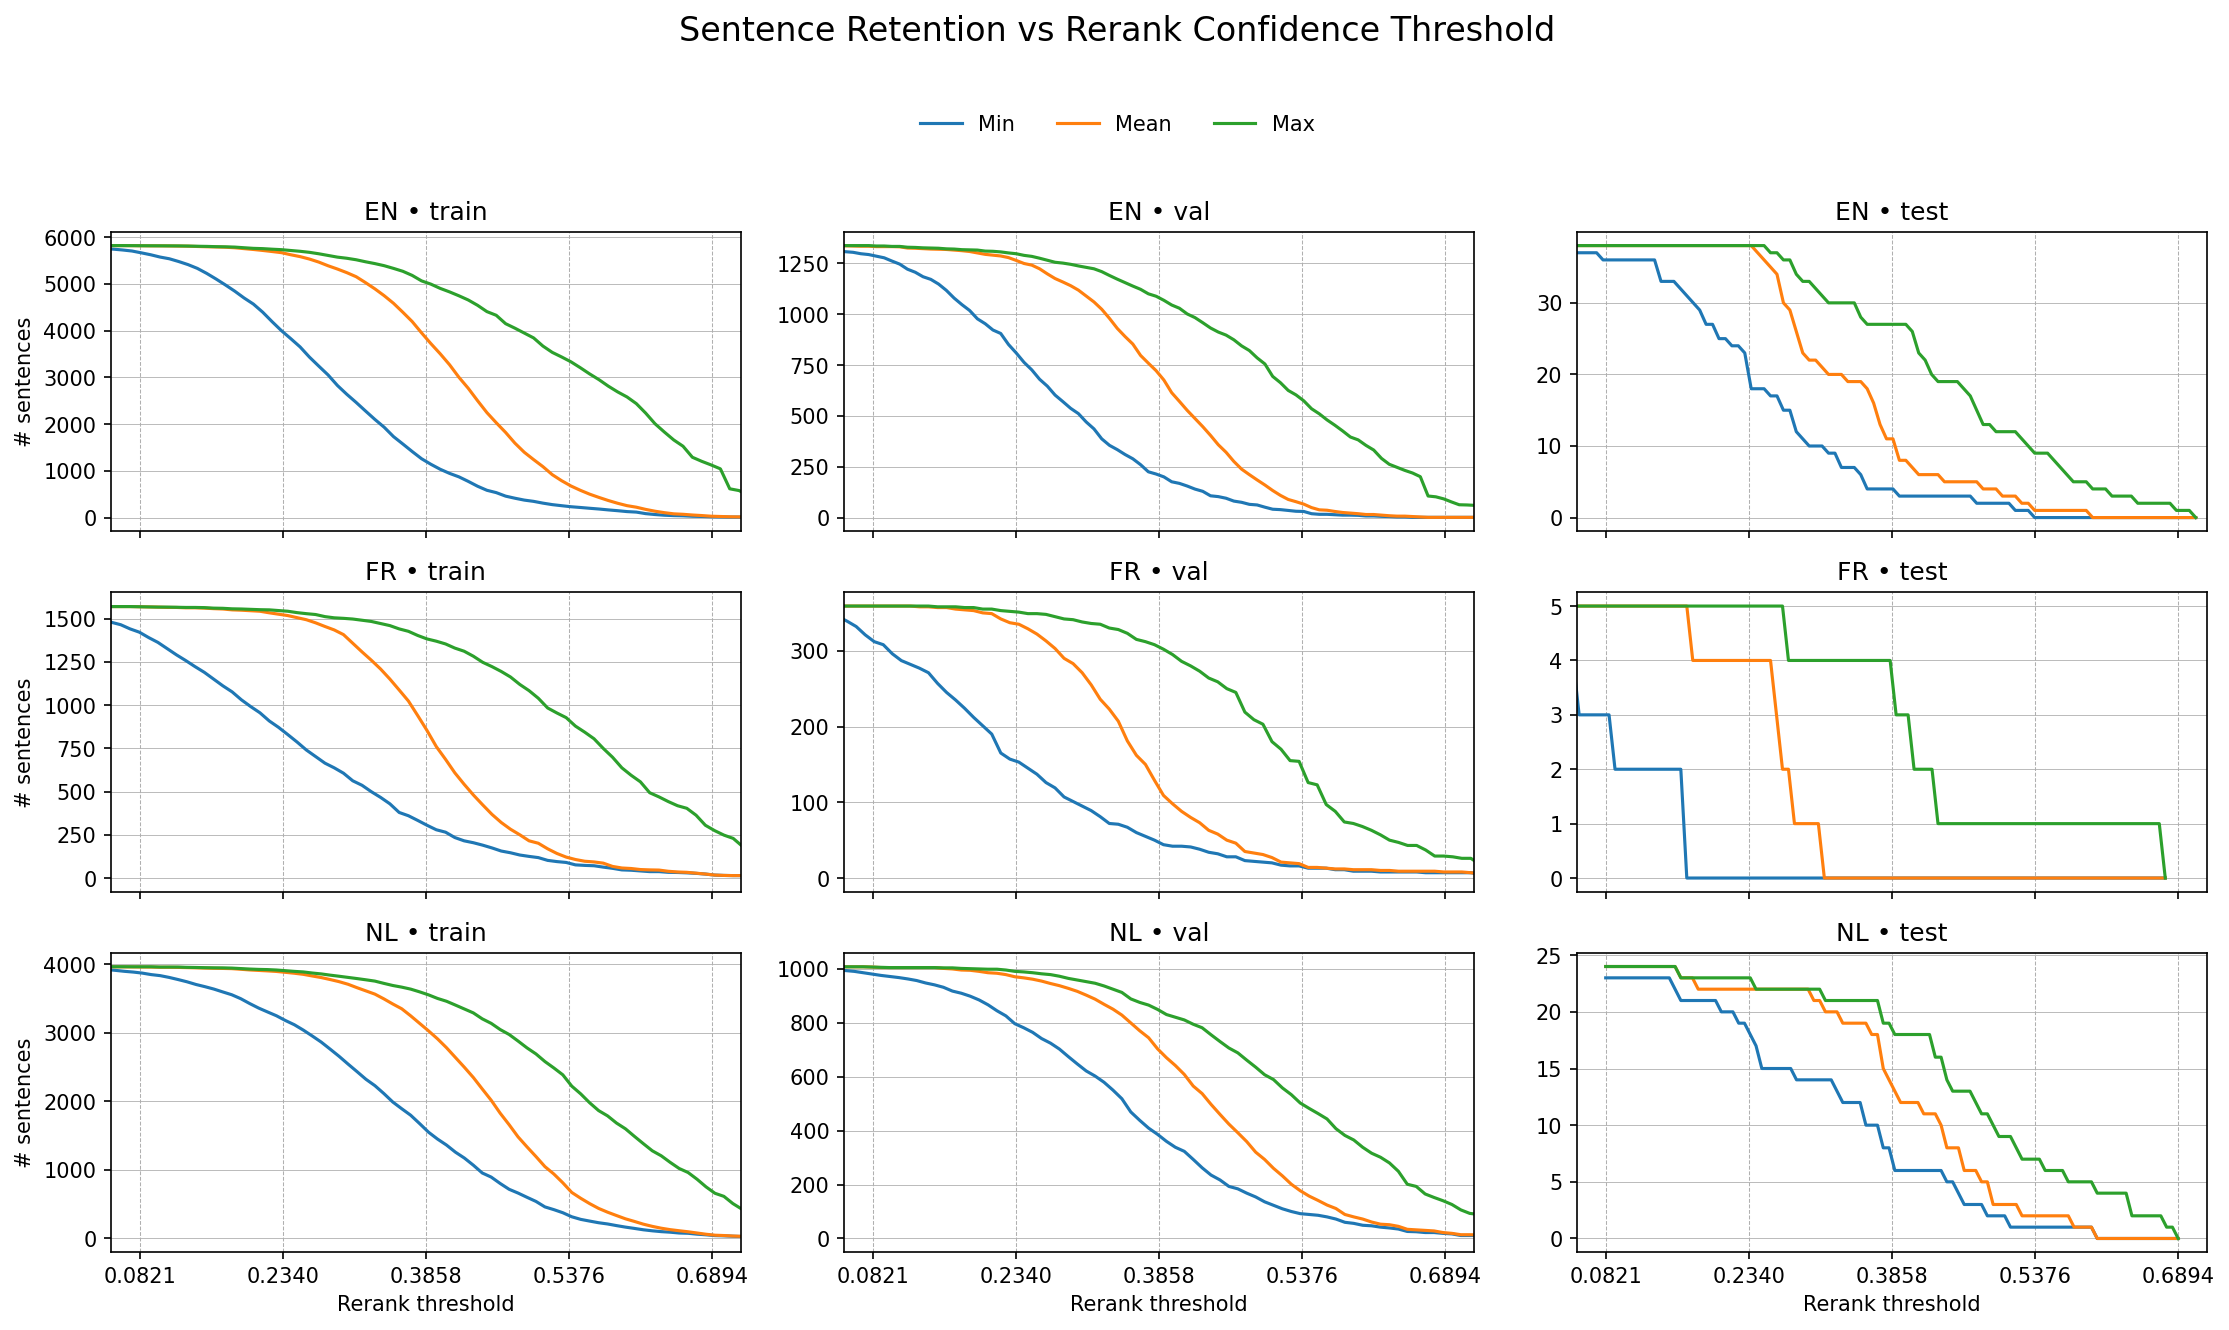

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from extractomat.tester import TermEvaluator

languages = list(rerank_results.keys())
splits    = list(next(iter(rerank_results.values())).keys())

fig, axes = plt.subplots(len(languages), len(splits),
                         figsize=(15, 9), dpi=150,
                         sharex=True, sharey=False)

for i, lang in enumerate(languages):
    for j, split in enumerate(splits):
        ax        = axes[i, j]
        r_scores  = rerank_results[lang][split]
        term_occ  = c_value_results[lang][split]["term_occ"]

        if not r_scores or not term_occ:
            ax.axis("off")
            continue

        # bucket rerank scores by sentence
        bucket_r = defaultdict(list)
        for term, spans in term_occ.items():
            score = r_scores.get(term)
            if score is None: continue
            for span in spans:
                bucket_r[span.sent].append(score)

        # compute per-sentence stats
        mins, means, maxs = [], [], []
        for scores in bucket_r.values():
            mins.append(min(scores))
            means.append(np.mean(scores))
            maxs.append(max(scores))
        mins  = np.array(mins)
        means = np.array(means)
        maxs  = np.array(maxs)

        # threshold range
        thr = np.linspace(mins.min(), maxs.max(), 100)

        # count sentences above each threshold
        cnt_min  = [(mins  > t).sum() for t in thr]
        cnt_mean = [(means > t).sum() for t in thr]
        cnt_max  = [(maxs  > t).sum() for t in thr]

        # plot curves
        ax.plot(thr, cnt_min,  label="Min")
        ax.plot(thr, cnt_mean, label="Mean")
        ax.plot(thr, cnt_max,  label="Max")

        # calculate 5% padding
        x0, x1 = thr.min(), thr.max()
        y0, y1 = 0, max(cnt_min + cnt_mean + cnt_max)
        x_pad  = 0.05 * (x1 - x0)
        y_pad  = 0.05 * (y1 - y0)

        # apply padding
        ax.set_xlim(x0 - x_pad, x1 + x_pad)
        ax.set_ylim(y0 - y_pad, y1 + y_pad)

        # set ticks and grids
        ax.set_xticks(np.linspace(x0, x1, 5))
        ax.grid(axis="x", linestyle="--", linewidth=0.5)
        ax.grid(axis="y", linewidth=0.4)

        # labels and titles
        if i == len(languages) - 1:
            ax.set_xlabel("Rerank threshold")
        if j == 0:
            ax.set_ylabel("# sentences")
        ax.set_title(f"{lang.upper()} • {split}")

# overall title and legend
fig.suptitle("Sentence Retention vs Rerank Confidence Threshold", fontsize=16)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
            loc="upper center",
            bbox_to_anchor=(0.5, 0.92),
            ncol=3,
            frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


[Rerank] EN train:  P=0.100  R=0.521  F1=0.168
[Rerank] EN val  :  P=0.125  R=0.574  F1=0.205
[Rerank] EN test :  P=0.147  R=0.535  F1=0.231
[Rerank] FR train:  P=0.051  R=0.127  F1=0.073
[Rerank] FR val  :  P=0.062  R=0.171  F1=0.091
[Rerank] FR test :  P=0.149  R=0.159  F1=0.154
[Rerank] NL train:  P=0.064  R=0.431  F1=0.112
[Rerank] NL val  :  P=0.090  R=0.359  F1=0.144
[Rerank] NL test :  P=0.114  R=0.294  F1=0.164


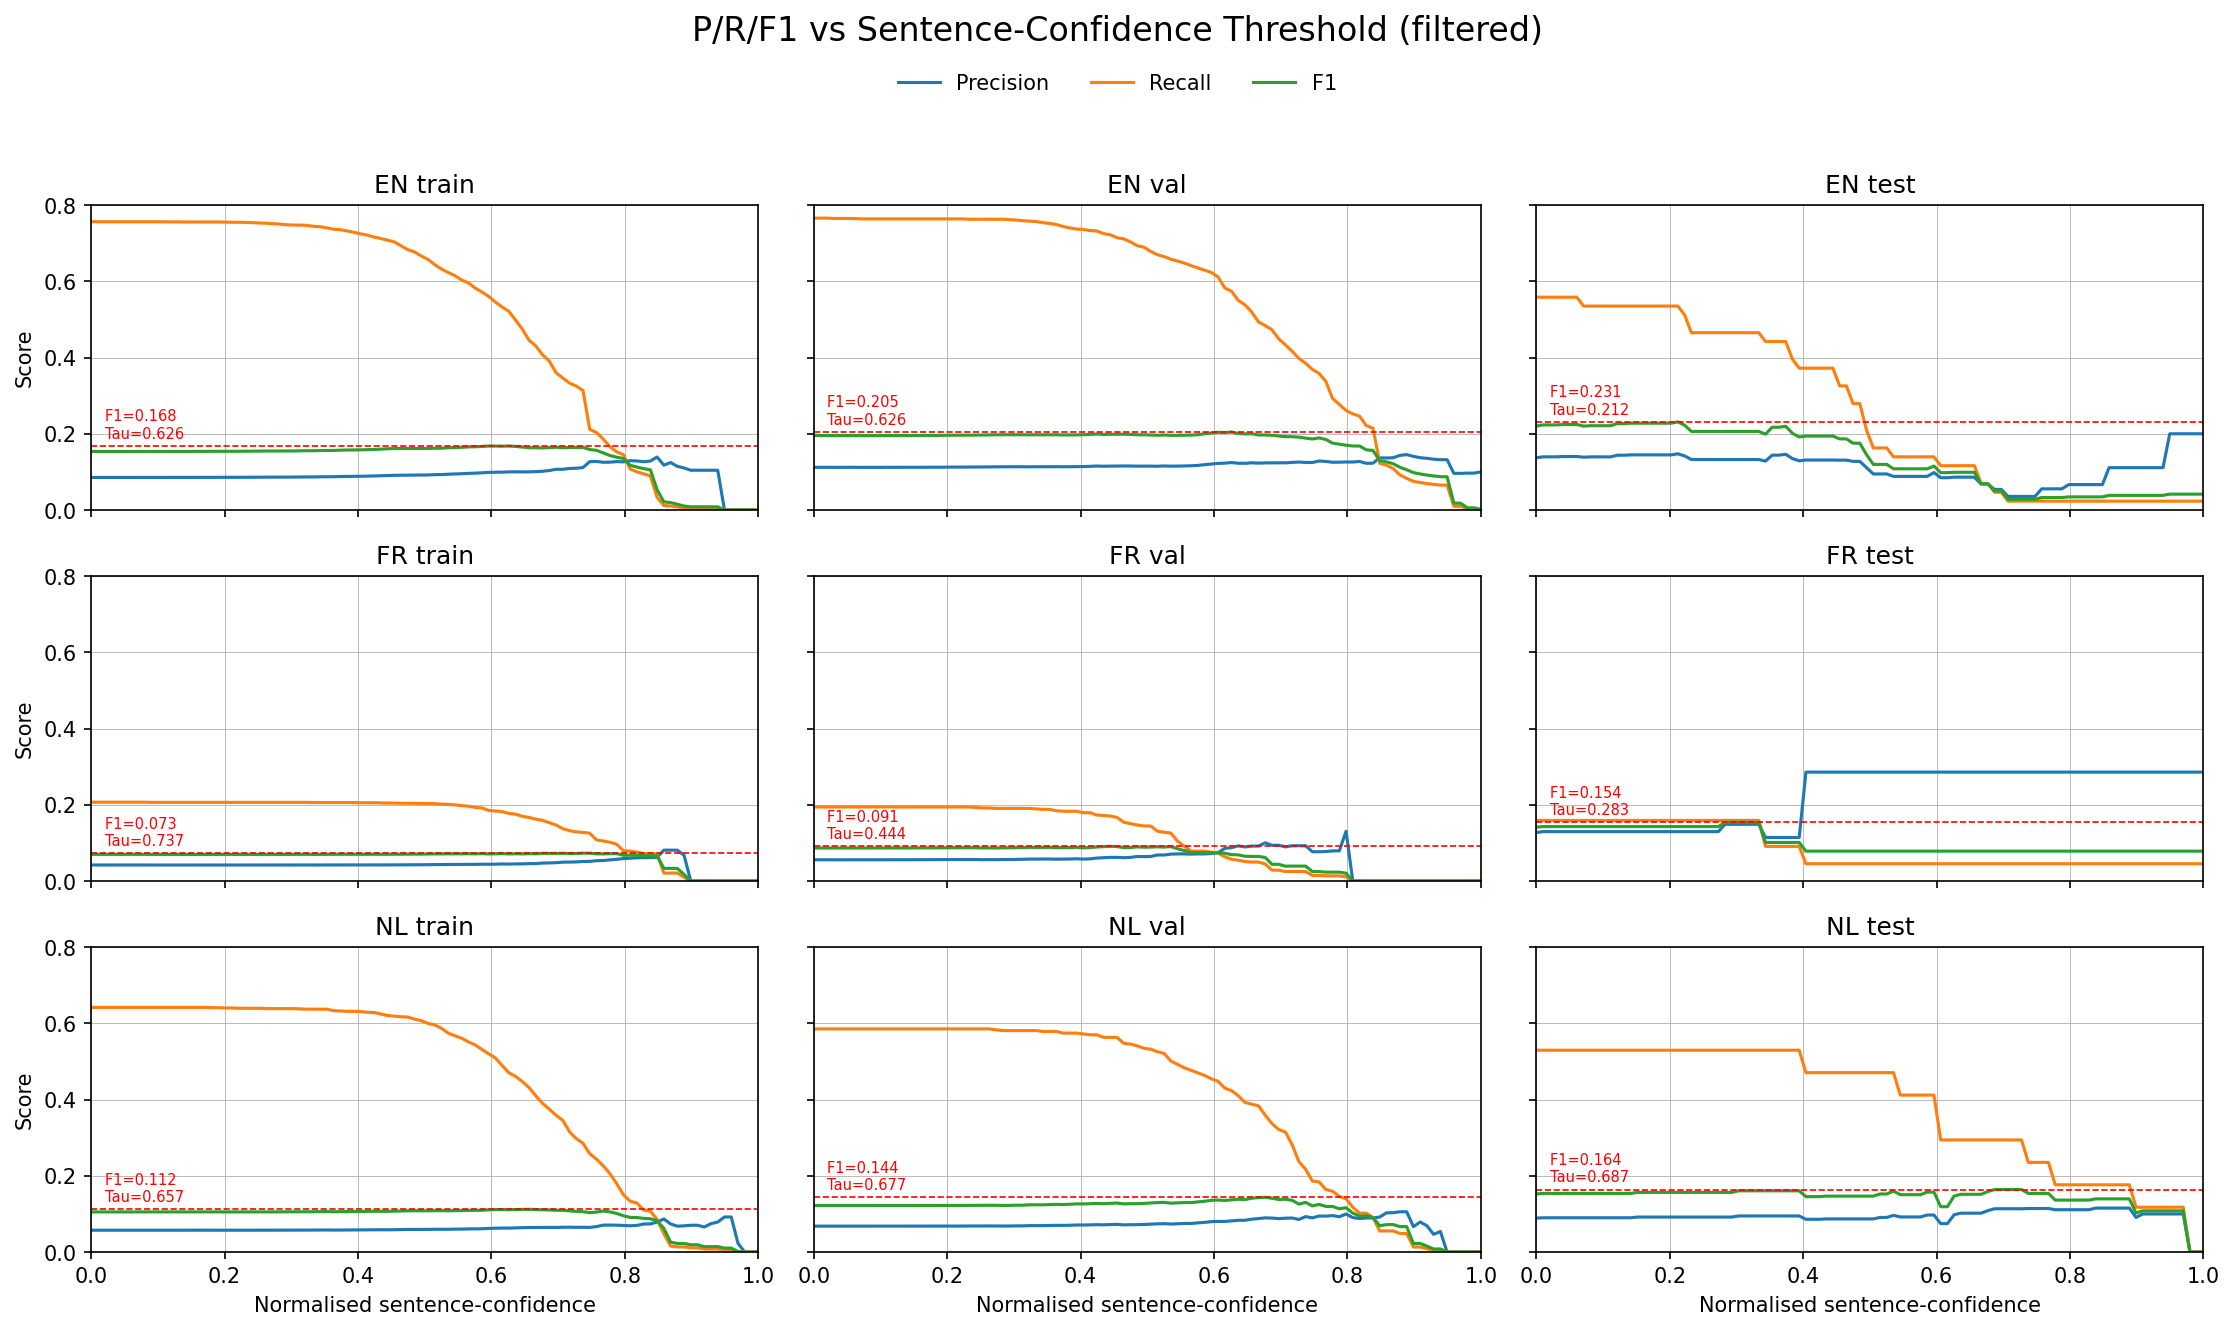

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from extractomat.tester import TermEvaluator

languages = list(rerank_results.keys())
splits    = list(next(iter(rerank_results.values())).keys())

fig, axes = plt.subplots(len(languages), len(splits),
                         figsize=(15, 9), dpi=150,
                         sharex=True, sharey=True)

for r, lang in enumerate(languages):
    for c, split in enumerate(splits):
        ax      = axes[r, c]
        scores  = rerank_results[lang][split]            # term → max‐sentence confidence
        term_occ = c_value_results[lang][split]["term_occ"]

        if not scores or not term_occ:
            ax.axis("off"); continue

        # bucket rerank scores by sentence
        bucket_r = defaultdict(list)
        for term, spans in term_occ.items():
            sc = scores.get(term)
            if sc is None: continue
            for span in spans:
                bucket_r[span.sent].append(sc)

        # sentence‐level confidences (max)
        sent_max = {s: max(vs) for s, vs in bucket_r.items()}
        vals     = np.array(list(sent_max.values()))

        # sweep thresholds over [min..max]
        abs_thr  = np.linspace(vals.min(), vals.max(), 100)
        norm_thr = (abs_thr - vals.min()) / (vals.max() - vals.min())

        P = np.zeros_like(abs_thr)
        R = np.zeros_like(abs_thr)
        F = np.zeros_like(abs_thr)

        # precompute gold path and minimal term threshold
        gt_csv = Path(language_output_dirs[lang][split]) \
                   .with_suffix("").joinpath("gt_labels.csv")
        for i, t in enumerate(abs_thr):
            # 1) select sentences >= t
            keep_sents = {s for s, m in sent_max.items() if m >= t}

            # 2) prune term_occ to those sentences
            pruned_occ = {}
            for term, spans in term_occ.items():
                fsp = [sp for sp in spans if sp.sent in keep_sents]
                if fsp:
                    pruned_occ[term] = fsp

            pruned_scores = {term: scores[term] for term in pruned_occ}

            # 3) evaluate on pruned corpus (threshold=lowest so all terms in pruned_occ get scored)
            ev = TermEvaluator(gt_csv,
                               pruned_scores,
                               pruned_occ,
                               method="rerank",
                               language=lang)
            try:
                P[i], R[i], F[i] = ev.calculate_metrics(abs_thr[0] - 1e-9)
            except ZeroDivisionError:
                P[i] = R[i] = F[i] = 0.0

        # plot
        ax.plot(norm_thr, P, label="Precision")
        ax.plot(norm_thr, R, label="Recall")
        ax.plot(norm_thr, F, label="F1")

        best = np.argmax(F)

        ax.set_ylim(0, 0.8)
        ax.set_xlim(0, 1)

        ax.axhline(F[best], color="red", ls="--", lw=0.8)
        ax.text(0.02, F[best] + 0.02,
                f"F1={F[best]:.3f} \nTau={norm_thr[best]:.3f}", color="red", fontsize=7)

        if r == len(languages) - 1:
            ax.set_xlabel("Normalised sentence-confidence")
        if c == 0:
            ax.set_ylabel("Score")

        ax.set_title(f"{lang.upper()} {split}")
        ax.grid(True, lw=0.4)

        print(f"[Rerank] {lang.upper()} {split:5}:  "
              f"P={P[best]:.3f}  R={R[best]:.3f}  F1={F[best]:.3f}")

# legend & title
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc="upper center",
           bbox_to_anchor=(0.5,0.95),
           ncol=3, frameon=False)
fig.suptitle("P/R/F1 vs Sentence-Confidence Threshold (filtered)", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

[Rerank] EN min  :  P=0.149  R=0.340  F1=0.207 % Sentences Retained=17.20% Tau=0.374
[Rerank] EN mean :  P=0.138  R=0.435  F1=0.210 % Sentences Retained=10.25% Tau=0.505
[Rerank] EN max  :  P=0.125  R=0.574  F1=0.205 % Sentences Retained=20.79% Tau=0.626
[Rerank] FR min  :  P=0.059  R=0.202  F1=0.091 % Sentences Retained=83.01% Tau=0.101
[Rerank] FR mean :  P=0.055  R=0.200  F1=0.087 % Sentences Retained=100.00% Tau=0.071
[Rerank] FR max  :  P=0.062  R=0.171  F1=0.091 % Sentences Retained=72.70% Tau=0.444
[Rerank] NL min  :  P=0.079  R=0.330  F1=0.127 % Sentences Retained=33.43% Tau=0.404
[Rerank] NL mean :  P=0.076  R=0.463  F1=0.131 % Sentences Retained=44.44% Tau=0.455
[Rerank] NL max  :  P=0.090  R=0.359  F1=0.144 % Sentences Retained=15.28% Tau=0.677


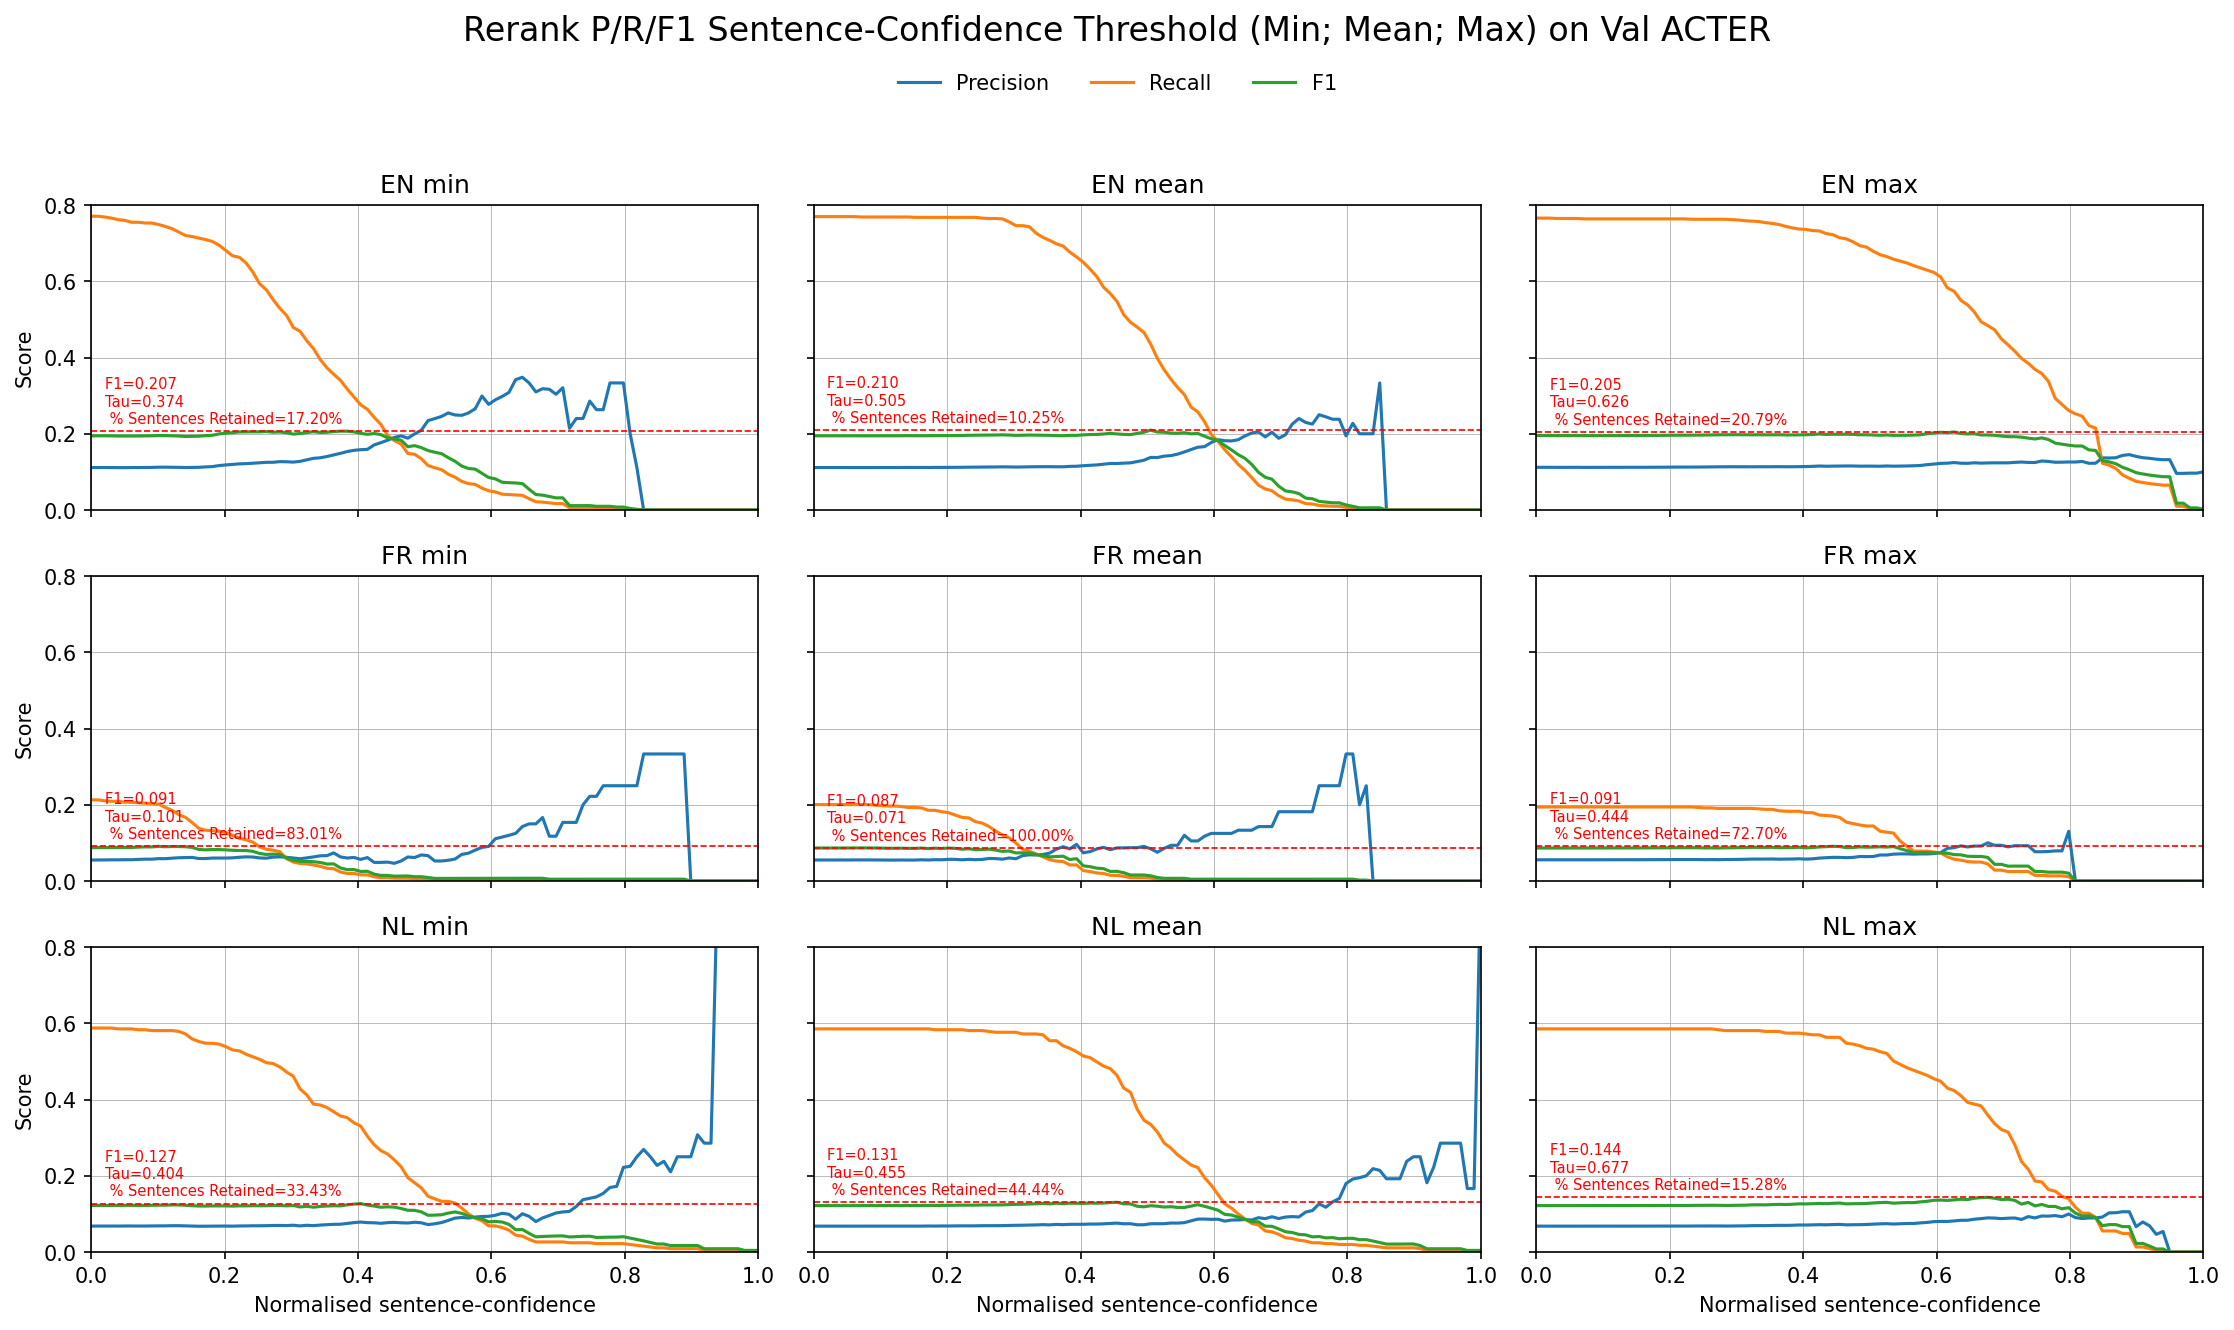

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from extractomat.tester import TermEvaluator

languages = list(rerank_results.keys())
sentence_selection_methods = ["min", "mean", "max"]

fig, axes = plt.subplots(len(languages), len(splits),
                         figsize=(15, 9), dpi=150,
                         sharex=True, sharey=True)

for r, lang in enumerate(languages):
    for c, method in enumerate(sentence_selection_methods):
        split = "val"

        ax      = axes[r, c]
        scores  = rerank_results[lang][split]            # term → max‐sentence confidence
        term_occ = c_value_results[lang][split]["term_occ"]

        if not scores or not term_occ:
            ax.axis("off"); continue

        # bucket rerank scores by sentence
        bucket_r = defaultdict(list)
        for term, spans in term_occ.items():
            sc = scores.get(term)
            if sc is None: continue
            for span in spans:
                bucket_r[span.sent].append(sc)

        sent_method = {s: min(vs) for s, vs in bucket_r.items()} if method == "min" else \
                      {s: np.mean(vs) for s, vs in bucket_r.items()} if method == "mean" else \
                      {s: max(vs) for s, vs in bucket_r.items()}

        vals     = np.array(list(sent_method.values()))

        # sweep thresholds over [min..max]
        abs_thr  = np.linspace(vals.min(), vals.max(), 100)
        norm_thr = (abs_thr - vals.min()) / (vals.max() - vals.min())

        P = np.zeros_like(abs_thr)
        R = np.zeros_like(abs_thr)
        F = np.zeros_like(abs_thr)

        # precompute gold path and minimal term threshold
        gt_csv = Path(language_output_dirs[lang][split]) \
                   .with_suffix("").joinpath("gt_labels.csv")
        for i, t in enumerate(abs_thr):
            # 1) select sentences >= t
            keep_sents = {s for s, m in sent_method.items() if m >= t}

            # 2) prune term_occ to those sentences
            pruned_occ = {}
            for term, spans in term_occ.items():
                fsp = [sp for sp in spans if sp.sent in keep_sents]
                if fsp:
                    pruned_occ[term] = fsp

            pruned_scores = {term: scores[term] for term in pruned_occ}

            # 3) evaluate on pruned corpus (threshold=lowest so all terms in pruned_occ get scored)
            ev = TermEvaluator(gt_csv,
                               pruned_scores,
                               pruned_occ,
                               method="rerank",
                               language=lang)
            try:
                P[i], R[i], F[i] = ev.calculate_metrics(abs_thr[0] - 1e-9)
            except ZeroDivisionError:
                P[i] = R[i] = F[i] = 0.0

        # plot
        ax.plot(norm_thr, P, label="Precision")
        ax.plot(norm_thr, R, label="Recall")
        ax.plot(norm_thr, F, label="F1")

        best = np.argmax(F)
        percentage_sentences_retained = len({s for s, m in sent_method.items() if m >= norm_thr[best]}) / len(sent_method)

        ax.set_ylim(0, 0.8)
        ax.set_xlim(0, 1)

        ax.axhline(F[best], color="red", ls="--", lw=0.8)
        ax.text(0.02, F[best] + 0.02,
                f"F1={F[best]:.3f} \nTau={norm_thr[best]:.3f} \n % Sentences Retained={percentage_sentences_retained*100:.2f}%", color="red", fontsize=7)

        if r == len(languages) - 1:
            ax.set_xlabel("Normalised sentence-confidence")
        if c == 0:
            ax.set_ylabel("Score")

        ax.set_title(f"{lang.upper()} {method}")
        ax.grid(True, lw=0.4)

        print(f"[Rerank] {lang.upper()} {method:5}:  "
              f"P={P[best]:.3f}  R={R[best]:.3f}  F1={F[best]:.3f} % Sentences Retained={percentage_sentences_retained*100:.2f}% Tau={norm_thr[best]:.3f}")

# legend & title
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc="upper center",
           bbox_to_anchor=(0.5,0.95),
           ncol=3, frameon=False)
fig.suptitle("Rerank P/R/F1 Sentence-Confidence Threshold (Min; Mean; Max) on Val ACTER", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

[C-Value] EN min  :  P=0.113  R=0.741  F1=0.196 % Sentences Retained=46.22% Tau=0.030
[C-Value] EN mean :  P=0.150  R=0.467  F1=0.227 % Sentences Retained=100.00% Tau=0.020
[C-Value] EN max  :  P=0.141  R=0.494  F1=0.220 % Sentences Retained=100.00% Tau=0.020
[C-Value] FR min  :  P=0.057  R=0.210  F1=0.090 % Sentences Retained=55.15% Tau=0.020
[C-Value] FR mean :  P=0.061  R=0.192  F1=0.092 % Sentences Retained=99.72% Tau=0.040
[C-Value] FR max  :  P=0.060  R=0.193  F1=0.091 % Sentences Retained=99.72% Tau=0.071
[C-Value] NL min  :  P=0.115  R=0.217  F1=0.150 % Sentences Retained=66.37% Tau=0.040
[C-Value] NL mean :  P=0.101  R=0.188  F1=0.131 % Sentences Retained=100.00% Tau=0.051
[C-Value] NL max  :  P=0.089  R=0.284  F1=0.136 % Sentences Retained=100.00% Tau=0.081


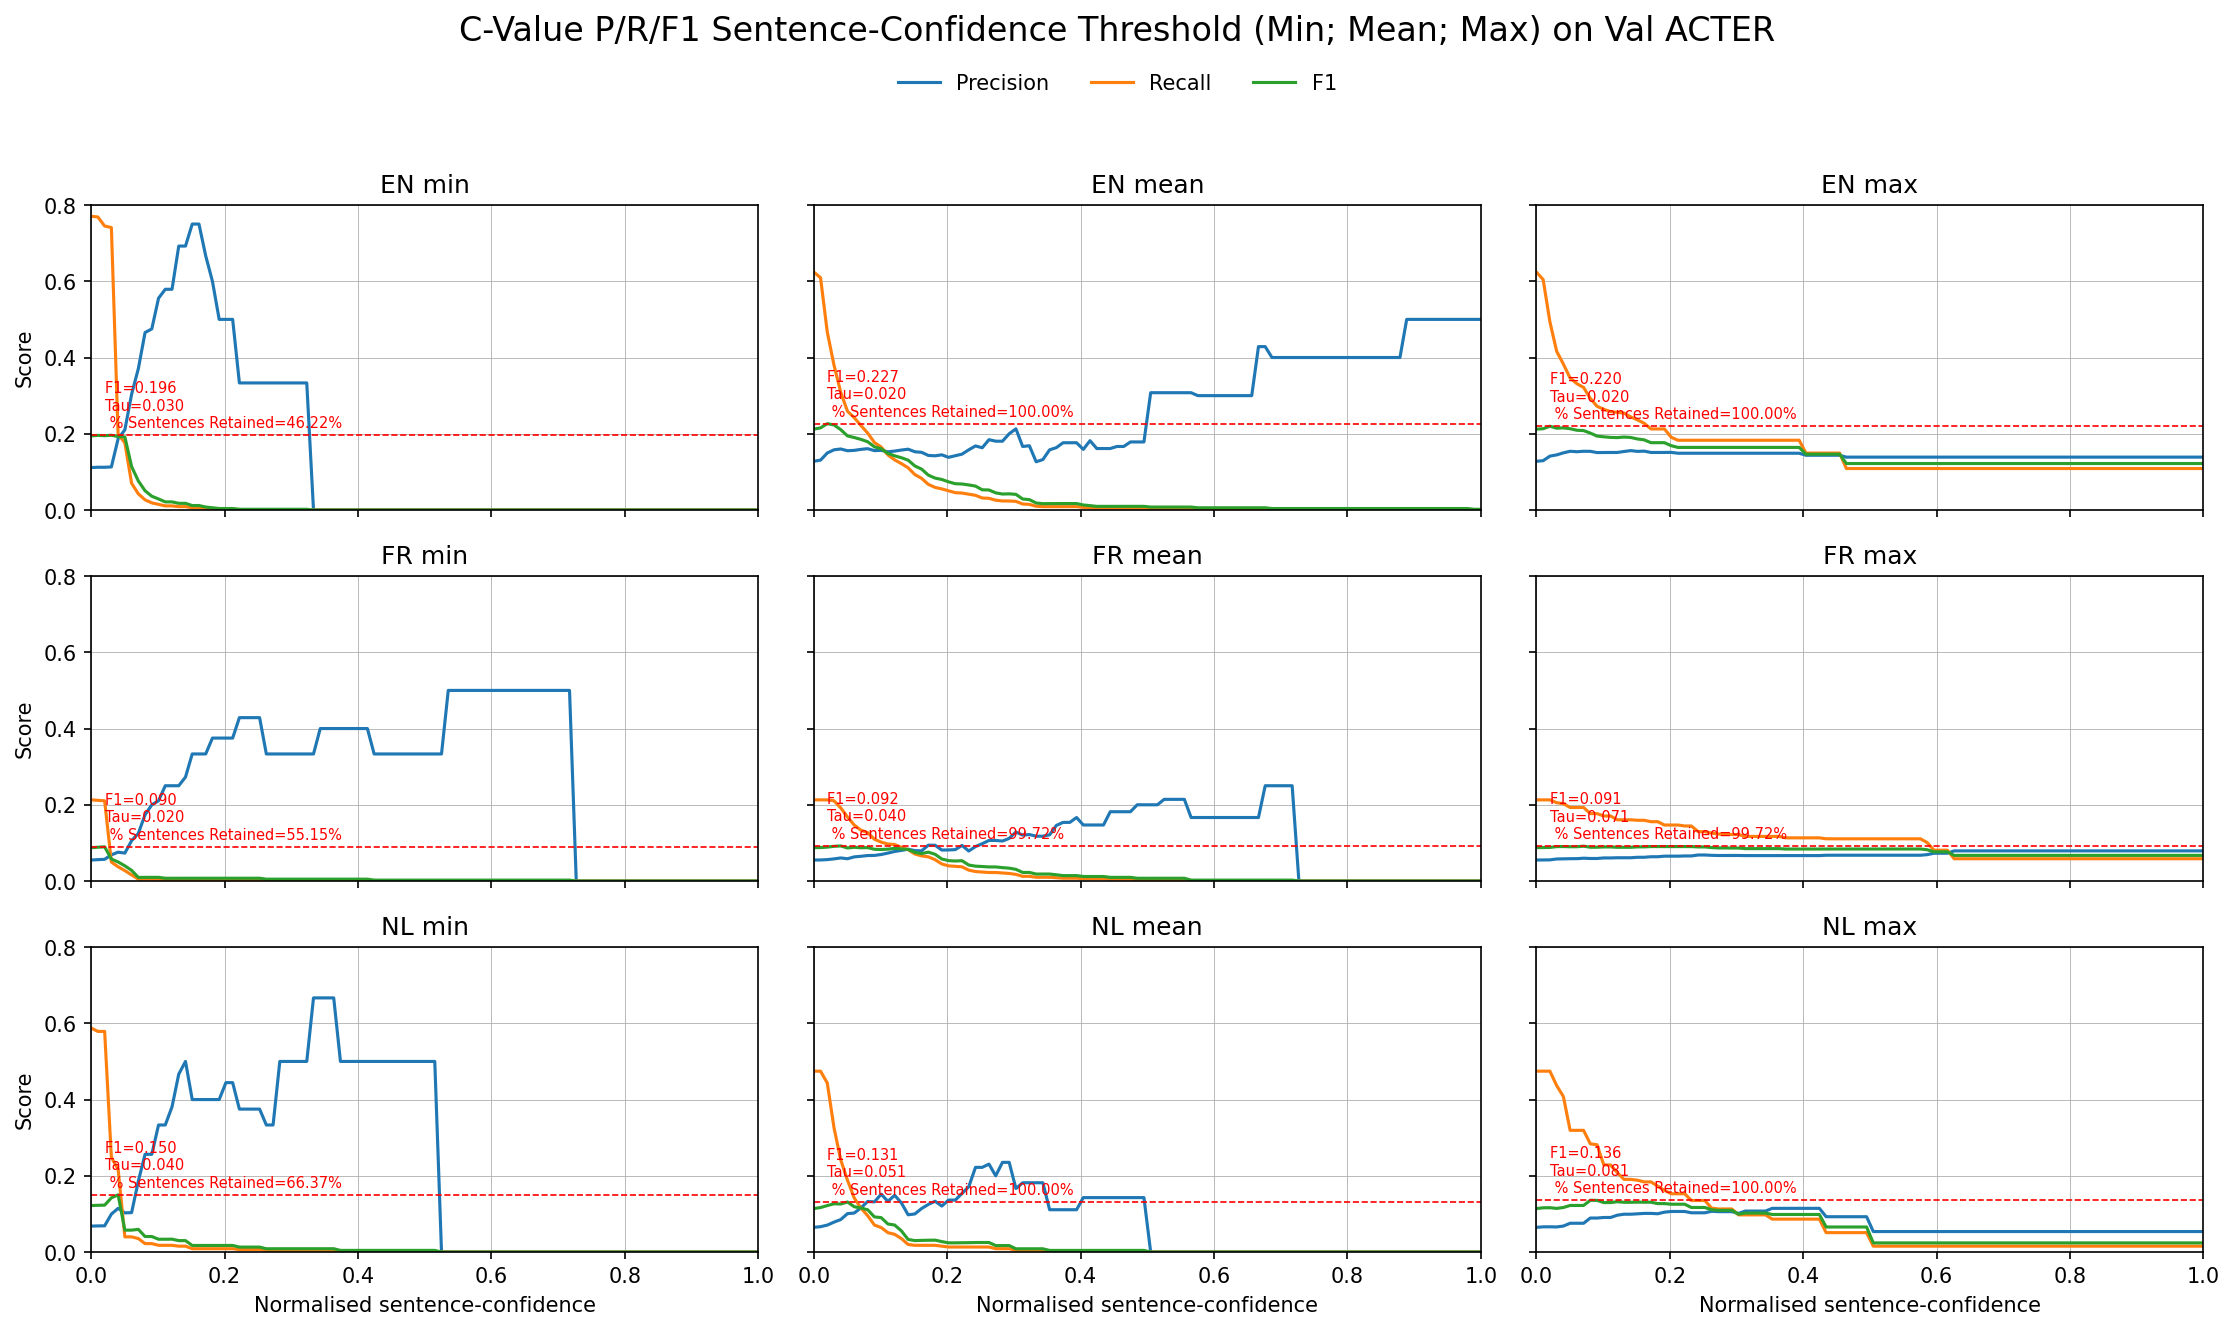

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from extractomat.tester import TermEvaluator

languages = list(rerank_results.keys())
sentence_selection_methods = ["min", "mean", "max"]

fig, axes = plt.subplots(len(languages), len(splits),
                         figsize=(15, 9), dpi=150,
                         sharex=True, sharey=True)

for r, lang in enumerate(languages):
    for c, method in enumerate(sentence_selection_methods):
        split = "val"

        ax      = axes[r, c]
        scores  = c_value_results[lang][split]["term_scores"]
        term_occ = c_value_results[lang][split]["term_occ"]

        if not scores or not term_occ:
            ax.axis("off"); continue

        # bucket rerank scores by sentence
        bucket_r = defaultdict(list)
        for term, spans in term_occ.items():
            sc = scores.get(term)
            if sc is None: continue
            for span in spans:
                bucket_r[span.sent].append(sc)

        sent_method = {s: min(vs) for s, vs in bucket_r.items()} if method == "min" else \
                      {s: np.mean(vs) for s, vs in bucket_r.items()} if method == "mean" else \
                      {s: max(vs) for s, vs in bucket_r.items()}

        vals     = np.array(list(sent_method.values()))

        # sweep thresholds over [min..max]
        abs_thr  = np.linspace(vals.min(), vals.max(), 100)
        norm_thr = (abs_thr - vals.min()) / (vals.max() - vals.min())

        P = np.zeros_like(abs_thr)
        R = np.zeros_like(abs_thr)
        F = np.zeros_like(abs_thr)

        # precompute gold path and minimal term threshold
        gt_csv = Path(language_output_dirs[lang][split]) \
                   .with_suffix("").joinpath("gt_labels.csv")
        for i, t in enumerate(abs_thr):
            # 1) select sentences >= t
            keep_sents = {s for s, m in sent_method.items() if m >= t}

            # 2) prune term_occ to those sentences
            pruned_occ = {}
            for term, spans in term_occ.items():
                fsp = [sp for sp in spans if sp.sent in keep_sents]
                if fsp:
                    pruned_occ[term] = fsp

            pruned_scores = {term: scores[term] for term in pruned_occ}

            # 3) evaluate on pruned corpus (threshold=lowest so all terms in pruned_occ get scored)
            ev = TermEvaluator(gt_csv,
                               pruned_scores,
                               pruned_occ,
                               method="cvalue",
                               language=lang)
            try:
                P[i], R[i], F[i] = ev.calculate_metrics(abs_thr[0] - 1e-9)
            except ZeroDivisionError:
                P[i] = R[i] = F[i] = 0.0

        # plot
        ax.plot(norm_thr, P, label="Precision")
        ax.plot(norm_thr, R, label="Recall")
        ax.plot(norm_thr, F, label="F1")

        best = np.argmax(F)
        percentage_sentences_retained = len({s for s, m in sent_method.items() if m >= norm_thr[best]}) / len(sent_method)

        ax.set_ylim(0, 0.8)
        ax.set_xlim(0, 1)

        ax.axhline(F[best], color="red", ls="--", lw=0.8)
        ax.text(0.02, F[best] + 0.02,
                f"F1={F[best]:.3f} \nTau={norm_thr[best]:.3f} \n % Sentences Retained={percentage_sentences_retained*100:.2f}%", color="red", fontsize=7)

        if r == len(languages) - 1:
            ax.set_xlabel("Normalised sentence-confidence")
        if c == 0:
            ax.set_ylabel("Score")

        ax.set_title(f"{lang.upper()} {method}")
        ax.grid(True, lw=0.4)

        print(f"[C-Value] {lang.upper()} {method:5}:  "
              f"P={P[best]:.3f}  R={R[best]:.3f}  F1={F[best]:.3f} % Sentences Retained={percentage_sentences_retained*100:.2f}% Tau={norm_thr[best]:.3f}")

# legend & title
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc="upper center",
           bbox_to_anchor=(0.5,0.95),
           ncol=3, frameon=False)
fig.suptitle("C-Value P/R/F1 Sentence-Confidence Threshold (Min; Mean; Max) on Val ACTER", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

In [16]:
language_best_te_method = {
    "en": {"te_method": "rerank", "sentence_selection_method": None,  "tau": 0.525},
    "fr": {"te_method": "cvalue", "sentence_selection_method": None,  "tau": 0.030},
    "nl": {"te_method": "cvalue", "sentence_selection_method": "min", "tau": 0.040},
}

In [18]:
# from pathlib import Path
# from collections import defaultdict

# for lang, cfg in language_best_te_method.items():
#     te_method = cfg["te_method"]
#     sent_sel  = cfg["sentence_selection_method"]
#     tau       = cfg["tau"]

#     for split in splits:
#         # --- count original sentences ---
#         txt = Path(language_output_dirs[lang][split]).with_suffix("").joinpath("text.txt").read_text()
#         orig = sum(1 for block in txt.split("\n") if block.strip())

#         # --- build sent→scores as before ---
#         term_occ = c_value_results[lang][split]["term_occ"]
#         scores   = (c_value_results[lang][split]["term_scores"]
#                     if te_method=="cvalue" else rerank_results[lang][split])

#         sent2scores = defaultdict(list)
#         for term, spans in term_occ.items():
#             sc = scores.get(term, 0.0)
#             for sp in spans:
#                 sent2scores[sp.sent].append(sc)

#         # --- apply sentence‐level filter if any ---
#         kept = 0
#         for sent, scs in sent2scores.items():
#             metric = {"min":min, "mean":np.mean, "max":max}[sent_sel](scs)

#             if metric >= tau and sent_sel is not None:
#                 kept += 1
#             else:
#                 kept += 1

#         print(f"{lang.upper()} {split:5} → original = {orig:4d} sentences, kept = {kept:4d}")


KeyError: None

In [37]:
# import argparse
# import csv
# import os
# from pathlib import Path
# from typing import List, Optional, Tuple
# import random



# class SentenceTokens:
#     """Class to store tokens and labels for a sentence."""

#     def __init__(self) -> None:
#         """Initialize empty lists for tokens and labels."""
#         self.tokens: List[str] = []
#         self.labels: List[str] = []

#     def add_token(self, token: str, label: str) -> None:
#         """Add token and label to sentence.

#         Args:
#             token: Token text
#             label: IOB label
#         """
#         self.tokens.append(token)
#         self.labels.append(label)

#     def is_empty(self) -> bool:
#         """Check if sentence is empty.

#         Returns:
#             True if sentence has no tokens
#         """
#         return len(self.tokens) == 0

#     def get_sentence(self, normalize_spaces: bool = True) -> str:
#         """Get sentence as a string.

#         Args:
#             normalize_spaces: Whether to normalize spaces in the sentence
#         Returns:
#             Sentence as a string
#         """
#         if normalize_spaces:
#             return convert_tokenized_sent_to_str(self.tokens)

#         return " ".join(self.tokens)

#     def get_labels(self) -> List[str]:
#         """Return all labeled tokens in the sentence.
#         This is useful for extracting terms from the sentence.

#         Returns:
#             List of terms
#         """

#         joiner = " "
#         tokenized = self.tokens

#         labels = []
#         current_label = []

#         for label, token in zip(self.labels, tokenized):
#             if label in ["O", "B"]:
#                 if current_label:
#                     labels.append(joiner.join(map(str, current_label)))

#                 if label == "B":
#                     current_label = [token]
#                 else:
#                     current_label = []
#             elif label == "I":
#                 if current_label:
#                     current_label.append(token)
#                 else:
#                     current_label = [token]

#         if current_label:
#             labels.append(joiner.join(map(str, current_label)))

#         return labels

#     def to_tsv_lines(self) -> List[str]:
#         """Convert sentence to TSV lines.

#         Returns:
#             List of TSV formatted lines
#         """
#         return [f"{t}\t{l + '-TERM' if l != 'O' else l}" for t, l in zip(self.tokens, self.labels)]



# def read_iob_file(file_path: Path) -> List[SentenceTokens]:
#     sentences = []
#     current_sentence = SentenceTokens()
#     with open(file_path, "r", encoding="utf-8") as f:
#         for line in f:
#             line = line.strip()
#             if not line:  # Empty line indicates sentence boundary
#                 if not current_sentence.is_empty():
#                     sentences.append(current_sentence)
#                     current_sentence = SentenceTokens()
#                 continue
#             try:
#                 token, label = line.split("\t")
#                 current_sentence.add_token(token, label)
#             except ValueError as e:
#                 print(f"Warning: Skipping malformed line in {file_path}: {line}")
#                 continue
#     # Add last sentence if not empty
#     if not current_sentence.is_empty():
#         sentences.append(current_sentence)
#     return sentences

# for language, splits in c_value_results.items():
#     nlp = spacy.load(language_nlp_models[language], disable=["ner"])
#     nlp.max_length = 1500000

#     for subset, cv_data in splits.items():
#         subset_tsv = Path(language_output_dirs[language][subset])
#         subset_sentences = read_iob_file(subset_tsv)

#         #doc = nlp(Path(os.path.join(subset_tsv.with_suffix(''), "text.txt")).read_text().lower())

#         print(f"[{language}] {subset} – ", len(subset_sentences))

[en] train –  11343
[en] val –  2748
[en] test –  71
[fr] train –  9397
[fr] val –  2277
[fr] test –  59
[nl] train –  9525
[nl] val –  2308
[nl] test –  60


In [53]:
import bisect, numpy as np, pandas as pd
from pathlib import Path
from collections import defaultdict


root_out = Path("/content/drive/MyDrive/ucu/ner/new_threshold_datasets")
stats = []

for lang, cfg in language_best_te_method.items():
    te_method, sent_sel, tau = cfg["te_method"], cfg["sentence_selection_method"], cfg["tau"]
    sel_tag = sent_sel or "none"

    for split in c_value_results[lang]:
        tsv = Path(language_output_dirs[lang][split])
        sents = read_iob_file(tsv)

        starts, pos = [], 0
        for s in sents:
            starts.append(pos)
            pos += len(s)

        term_occ = c_value_results[lang][split]["term_occ"]
        scores = c_value_results[lang][split]["term_scores"] if te_method == "cvalue" else rerank_results[lang][split]

        s2sp = defaultdict(list)
        for term, spans in term_occ.items():
            sc = scores.get(term, 0.0)
            for sp in spans:
                idx = bisect.bisect_right(starts, sp.start) - 1
                s2sp[idx].append((sp, sc))

        if sent_sel:
            agg = {"min": min, "mean": np.mean, "max": max}[sent_sel]
            sent_score = {i: agg([sc for _, sc in arr]) for i, arr in s2sp.items()}

        out_path = (root_out / lang / f"{te_method}_{sel_tag}_{tau:.3f}_{split}.tsv")
        out_path.parent.mkdir(parents=True, exist_ok=True)

        b_cnt = i_cnt = o_cnt = kept_cnt = 0
        with out_path.open("w", encoding="utf-8") as fout:
            for i, s in enumerate(sents):
                if sent_sel and sent_score.get(i, 0.0) < tau:
                    continue                                  # drop sentence
                triples = [(sp, sc) for sp, sc in s2sp.get(i, []) if sc >= tau]

                lab = ["O"] * len(s)
                for sp, _ in triples:
                    st = sp.start - starts[i]
                    en = sp.end   - starts[i]
                    if 0 <= st < en <= len(lab):
                        lab[st] = "B-TERM"
                        for k in range(st + 1, en):
                            lab[k] = "I-TERM"

                b_cnt += lab.count("B-TERM")
                i_cnt += lab.count("I-TERM")
                o_cnt += lab.count("O")
                kept_cnt += 1

                for tok, lbl in zip(s, lab):
                    fout.write(f"{tok}\t{lbl}\n")
                fout.write("\n")

        orig_cnt = len(sents)
        stats.append({
            "language": lang, "split": split,
            "method": te_method, "sentence_sel": sel_tag, "tau": tau,
            "#orig_sent": orig_cnt,
            "#saved_sent": kept_cnt,
            "%retained": round(100 * kept_cnt / orig_cnt, 2),
            "#entities": b_cnt + i_cnt,
            "#b": b_cnt, "#i": i_cnt, "#o": o_cnt,
        })
        print(f"{out_path}  orig={orig_cnt}  kept={kept_cnt} "
              f"({100*kept_cnt/orig_cnt:.1f}%)  B={b_cnt} I={i_cnt} O={o_cnt}")

df = pd.DataFrame(stats)
from IPython.display import display
display(df)


/content/drive/MyDrive/ucu/ner/new_threshold_datasets/en/rerank_none_0.525_train.tsv  orig=11343  kept=11343 (100.0%)  B=5561 I=9235 O=164403
/content/drive/MyDrive/ucu/ner/new_threshold_datasets/en/rerank_none_0.525_val.tsv  orig=2748  kept=2748 (100.0%)  B=818 I=1423 O=39731
/content/drive/MyDrive/ucu/ner/new_threshold_datasets/en/rerank_none_0.525_test.tsv  orig=71  kept=71 (100.0%)  B=9 I=16 O=1085
/content/drive/MyDrive/ucu/ner/new_threshold_datasets/fr/cvalue_none_0.030_train.tsv  orig=9397  kept=9397 (100.0%)  B=10193 I=18216 O=164542
/content/drive/MyDrive/ucu/ner/new_threshold_datasets/fr/cvalue_none_0.030_val.tsv  orig=2277  kept=2277 (100.0%)  B=2449 I=4379 O=39150
/content/drive/MyDrive/ucu/ner/new_threshold_datasets/fr/cvalue_none_0.030_test.tsv  orig=59  kept=59 (100.0%)  B=75 I=123 O=1080
/content/drive/MyDrive/ucu/ner/new_threshold_datasets/nl/cvalue_min_0.040_train.tsv  orig=9525  kept=4874 (51.2%)  B=8249 I=11355 O=83759
/content/drive/MyDrive/ucu/ner/new_threshold_da

,language,split,method,sentence_sel,tau,#orig_sent,#saved_sent,%retained,#entities,#b,#i,#o
0,en,train,rerank,none,0.525,11343,11343,100.00,14796,5561,9235,164403
1,en,val,rerank,none,0.525,2748,2748,100.00,2241,818,1423,39731
2,en,test,rerank,none,0.525,71,71,100.00,25,9,16,1085
3,fr,train,cvalue,none,0.030,9397,9397,100.00,28409,10193,18216,164542
4,fr,val,cvalue,none,0.030,2277,2277,100.00,6828,2449,4379,39150
5,fr,test,cvalue,none,0.030,59,59,100.00,198,75,123,1080
6,nl,train,cvalue,min,0.040,9525,4874,51.17,19604,8249,11355,83759
7,nl,val,cvalue,min,0.040,2308,1090,47.23,4174,1770,2404,18844
8,nl,test,cvalue,min,0.040,60,29,48.33,109,47,62,714


In [30]:
# # --- Configuration (only these three language-specific settings are used) ----------
# language_best_te_method = {
#     "en": {"te_method": "rerank", "sentence_selection_method": None,  "tau": 0.525},
#     "fr": {"te_method": "cvalue", "sentence_selection_method": None,  "tau": 0.030},
#     "nl": {"te_method": "cvalue", "sentence_selection_method": "min", "tau": 0.040},
# }

# # --- Output directory -------------------------------------------------------------
# root_out = Path("/content/drive/MyDrive/ucu/ner/new_threshold_datasets")
# root_out.mkdir(parents=True, exist_ok=True)

# stats      = []
# languages  = list(language_best_te_method)                 # only EN / FR / NL
# splits     = list(c_value_results["en"].keys())            # train / val / test …

# for lang in languages:
#     cfg       = language_best_te_method[lang]
#     te_method = cfg["te_method"]               # 'cvalue' or 'rerank'
#     sent_sel  = cfg["sentence_selection_method"]  # None / min / mean / max
#     tau       = cfg["tau"]                     # confidence threshold

#     for split in splits:
#         # -------------------------------------------------------------------------
#         term_occ = c_value_results[lang][split]["term_occ"]
#         scores   = (c_value_results[lang][split]["term_scores"]
#                     if te_method == "cvalue"
#                     else rerank_results[lang][split])

#         # sentence → (term, span, score) mapping
#         sent2spans = defaultdict(list)
#         for term, spans in term_occ.items():
#             sc = scores.get(term, 0.0)
#             for sp in spans:
#                 sent2spans[sp.sent].append((term, sp, sc))

#         # sentence-level aggregation if requested
#         if sent_sel is not None:
#             agg = {"min": min, "mean": np.mean, "max": max}[sent_sel]
#             sent_score = {s: agg([sc for _, _, sc in triples])
#                           for s, triples in sent2spans.items()}

#         # output file
#         sel_tag = sent_sel or "none"
#         fname   = f"{te_method}_{sel_tag}_{tau:.3f}_{split}.tsv"
#         out_dir = root_out / lang
#         out_dir.mkdir(exist_ok=True)
#         out_path = out_dir / fname
#         out_path.unlink(missing_ok=True)

#         # write TSV
#         b_cnt = i_cnt = o_cnt = sent_cnt = 0
#         with out_path.open("w", encoding="utf-8") as fout:
#             for sent, triples in sent2spans.items():
#                 if sent_sel is not None and sent_score[sent] < tau:
#                     continue

#                 filtered = [(t, sp, sc) for t, sp, sc in triples if sc >= tau]
#                 if not filtered:
#                     continue

#                 labels = ["O"] * len(sent)
#                 for _, sp, _ in filtered:
#                     start = sp.start - sent.start
#                     end   = sp.end   - sent.start
#                     if start < 0 or end <= start:
#                         continue
#                     labels[start] = "B-TERM"
#                     for k in range(start + 1, end):
#                         if k < len(labels):
#                             labels[k] = "I-TERM"

#                 for tok, lbl in zip(sent, labels):
#                     if lbl == "O":           o_cnt += 1
#                     elif lbl == "B-TERM":    b_cnt += 1
#                     else:                    i_cnt += 1
#                     fout.write(f"{tok.text}\t{lbl}\n")
#                 fout.write("\n")
#                 sent_cnt += 1

#         stats.append({
#             "language": lang,  "split": split,
#             "method": te_method, "sentence_sel": sel_tag, "tau": tau,
#             "#sentences": sent_cnt, "#entities": b_cnt + i_cnt,
#             "#b": b_cnt, "#i": i_cnt, "#o": o_cnt,
#         })
#         print(f"Wrote {out_path}: sentences={sent_cnt}, B={b_cnt}, I={i_cnt}, O={o_cnt}")




Wrote /content/drive/MyDrive/ucu/ner/new_threshold_datasets/en/rerank_none_0.525_train.tsv: sentences=5822, B=6747, I=10836, O=168163
Wrote /content/drive/MyDrive/ucu/ner/new_threshold_datasets/en/rerank_none_0.525_val.tsv: sentences=1337, B=976, I=1638, O=41107
Wrote /content/drive/MyDrive/ucu/ner/new_threshold_datasets/en/rerank_none_0.525_test.tsv: sentences=38, B=12, I=23, O=1146
Wrote /content/drive/MyDrive/ucu/ner/new_threshold_datasets/fr/cvalue_none_0.030_train.tsv: sentences=1572, B=12158, I=21335, O=174173
Wrote /content/drive/MyDrive/ucu/ner/new_threshold_datasets/fr/cvalue_none_0.030_val.tsv: sentences=359, B=2885, I=5065, O=41867
Wrote /content/drive/MyDrive/ucu/ner/new_threshold_datasets/fr/cvalue_none_0.030_test.tsv: sentences=5, B=82, I=136, O=1154
Wrote /content/drive/MyDrive/ucu/ner/new_threshold_datasets/nl/cvalue_min_0.040_train.tsv: sentences=2693, B=6951, I=8705, O=75645
Wrote /content/drive/MyDrive/ucu/ner/new_threshold_datasets/nl/cvalue_min_0.040_val.tsv: sente

,language,split,method,sentence_sel,tau,#sentences,#entities,#b,#i,#o
0,en,train,rerank,none,0.525,5822,17583,6747,10836,168163
1,en,val,rerank,none,0.525,1337,2614,976,1638,41107
2,en,test,rerank,none,0.525,38,35,12,23,1146
3,fr,train,cvalue,none,0.030,1572,33493,12158,21335,174173
4,fr,val,cvalue,none,0.030,359,7950,2885,5065,41867
5,fr,test,cvalue,none,0.030,5,218,82,136,1154
6,nl,train,cvalue,min,0.040,2693,15656,6951,8705,75645
7,nl,val,cvalue,min,0.040,669,3501,1597,1904,18168
8,nl,test,cvalue,min,0.040,17,90,40,50,581


In [ ]:
# language_best_te_method = {
#     "en": {
#         "te_method": "rerank",
#         "sentence_selection_method": None,
#         "tau": 0.525,
#     },
#     "fr": {
#         "te_method": "cvalue",
#         "sentence_selection_method": None,
#         "tau": 0.03,
#     },
#     "nl": {
#         "te_method": "cvalue",
#         "sentence_selection_method": "min",
#         "tau": 0.040,
#     }
# }


# for lang in languages:
#     for split in splits:
#         te_method = language_best_te_method[lang]["te_method"]
#         sentence_selection_method = language_best_te_method[lang]["sentence_selection_method"]
#         tau = language_best_te_method[lang]["tau"]

#         term_occ = c_value_results[lang][split]["term_occ"]

#         if te_method == "cvalue":
#             scores = c_value_results[lang][split]["term_scores"]

#         else:
#             scores = rerank_results[lang][split]

#         if sentence_selection_method is not None:


#           # bucket rerank scores by sentence
#         bucket_r = defaultdict(list)
#         for term, spans in term_occ.items():
#             sc = scores.get(term)
#             if sc is None: continue
#             for span in spans:
#                 bucket_r[span.sent].append(sc)

#         sent_method = {s: min(vs) for s, vs in bucket_r.items()} if method == "min" else \
#                       {s: np.mean(vs) for s, vs in bucket_r.items()} if method == "mean" else \
#                       {s: max(vs) for s, vs in bucket_r.items()}

#         vals     = np.array(list(sent_method.values()))

#         for i, t in enumerate(abs_thr):
#             # 1) select sentences >= t
#             keep_sents = {s for s, m in sent_method.items() if m >= t}

#             # 2) prune term_occ to those sentences
#             pruned_occ = {}
#             for term, spans in term_occ.items():
#                 fsp = [sp for sp in spans if sp.sent in keep_sents]
#                 if fsp:
#                     pruned_occ[term] = fsp

#             pruned_scores = {term: scores[term] for term in pruned_occ}



#     for split, sent2spans in splits.items():
#         thr = best_thresholds[lang][split]
#         out_dir = Path("/content/drive/MyDrive/ucu/ner/threshold_datasets") / lang
#         out_dir.mkdir(exist_ok=True)
#         fname = f"rerank_{thr:.3f}_{split}.tsv"
#         out_path = out_dir / fname
#         out_path.unlink(missing_ok=True)

#         b_cnt = i_cnt = o_cnt = sent_cnt = 0
#         with out_path.open("w", encoding="utf-8") as fout:
#             for sent, spans in tqdm(sent2spans.items(), desc=f"Writing {lang}-{split}", unit="sent"):
#                 if max(sc for _, sc in spans) < thr:
#                     continue

#                 labels = ["O"] * len(sent)
#                 for span, sc in spans:
#                     if sc < thr:
#                         continue
#                     start = span.start - sent.start
#                     end   = span.end   - sent.start
#                     labels[start] = "B-TERM"
#                     for k in range(start+1, min(end, len(labels))):
#                         labels[k] = "I-TERM"

#                 for tok, lbl in zip(sent, labels):
#                     if lbl == "O":
#                         o_cnt += 1
#                     elif lbl == "B-TERM":
#                         b_cnt += 1
#                     else:
#                         i_cnt += 1
#                     fout.write(f"{tok.text}\t{lbl}\n")
#                 fout.write("\n")
#                 sent_cnt += 1

#         stats.append({
#             'language': lang,
#             'split': split,
#             'method': 'ReRank',
#             'aggregation': 'max',
#             'threshold': thr,
#             '#sentences': sent_cnt,
#             '#entities': b_cnt + i_cnt,
#             '#b': b_cnt,
#             '#i': i_cnt,
#             '#o': o_cnt
#         })
#         print(f"Wrote {out_path}: sentences={sent_cnt}, B={b_cnt}, I={i_cnt}, O={o_cnt}")

# # display summary
# df = pd.DataFrame(stats, columns=['language','split','method','aggregation','threshold',
#                                   '#sentences','#entities','#b','#i','#o'])
# from IPython.display import display
# display(df)


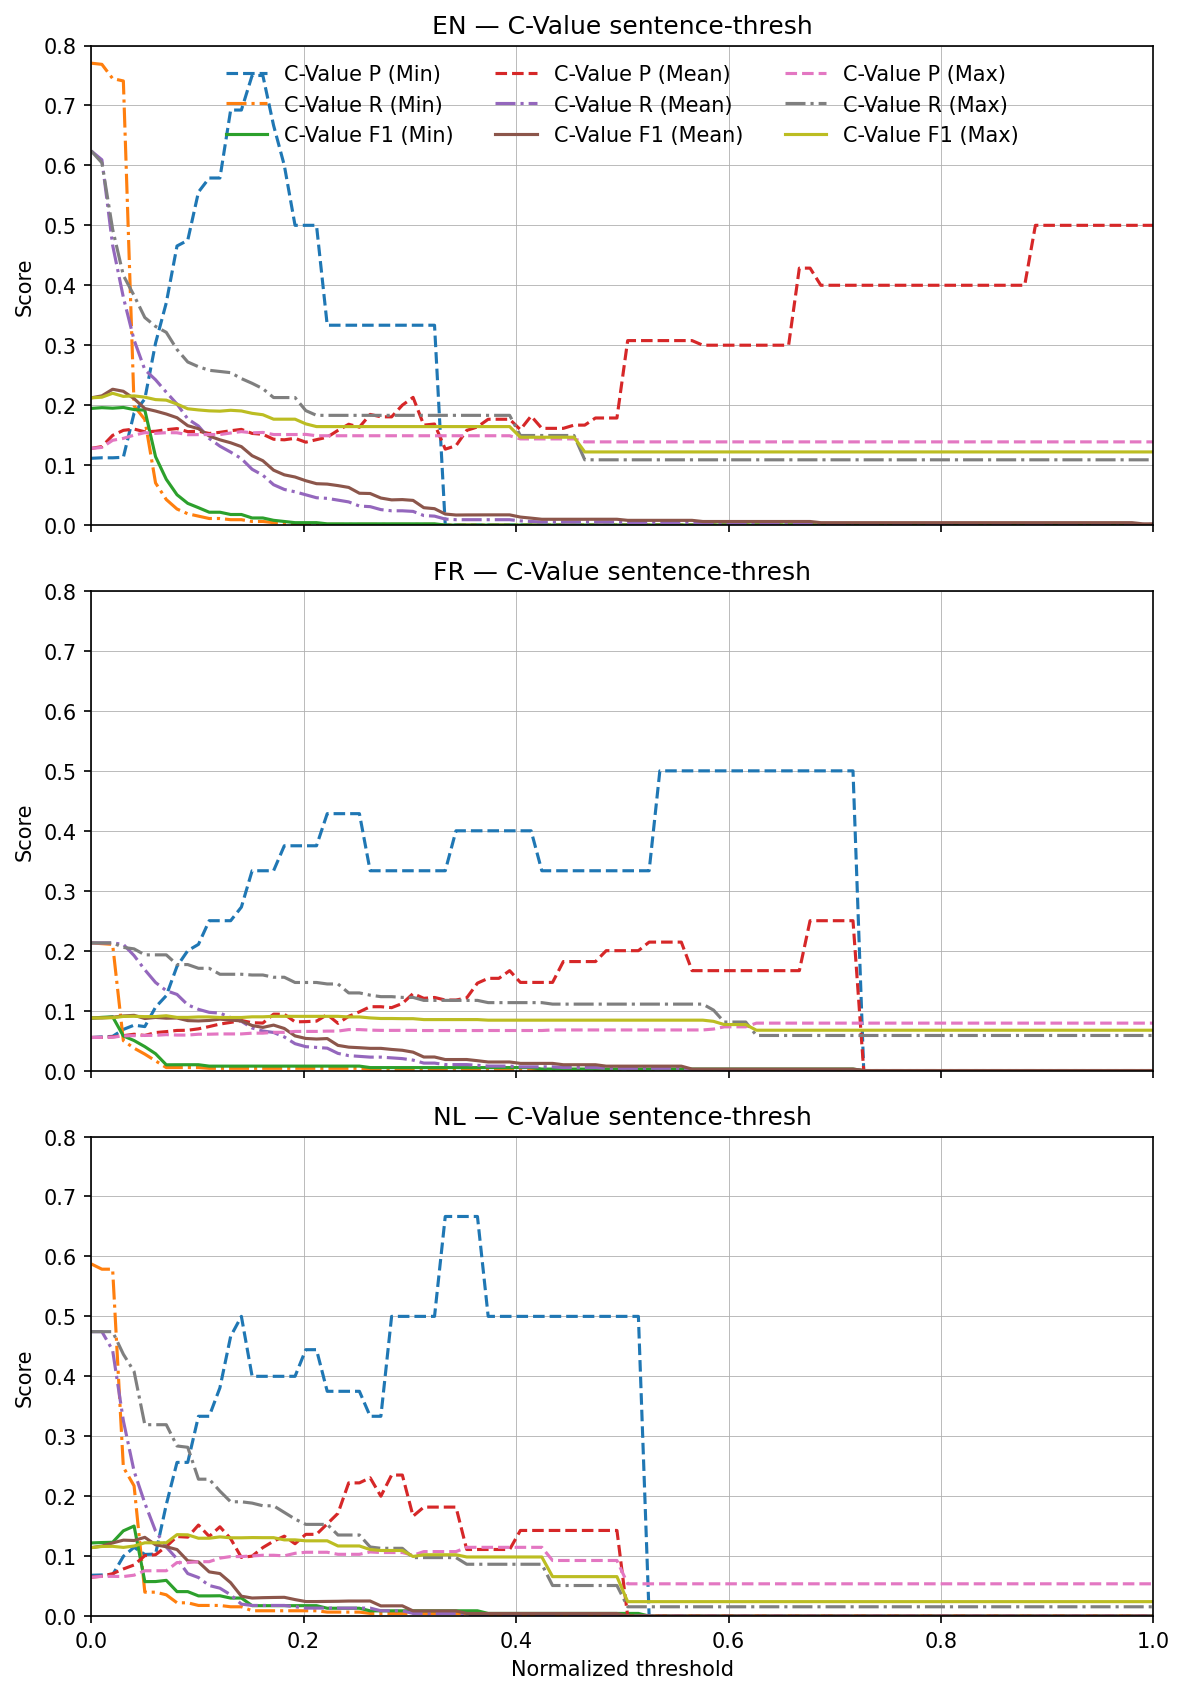

In [12]:
# # Cell 2: C-Value Sentence-Thresholding (Min / Mean / Max)
# import numpy as np
# import matplotlib.pyplot as plt
# from pathlib import Path
# from collections import defaultdict
# from extractomat.tester import TermEvaluator

# langs = list(c_value_results.keys())
# split = "val"

# fig, axes = plt.subplots(len(langs), 1, figsize=(8, 4*len(langs)), sharex=True, sharey=True, dpi=150)

# for i, lang in enumerate(langs):
#     ax = axes[i]
#     cv = c_value_results[lang][split]
#     term_occ = cv["term_occ"]
#     base_scores = cv["term_scores"]
#     gt_csv = Path(language_output_dirs[lang][split]).with_suffix("").joinpath("gt_labels.csv")

#     for agg_name, func in [("Min", min), ("Mean", np.mean), ("Max", max)]:
#         # bucket per sentence
#         bucket = defaultdict(list)
#         for term, spans in term_occ.items():
#             sc = base_scores.get(term,0)
#             for sp in spans:
#                 bucket[sp.sent].append(sc)
#         # sentence‐level values
#         vals = np.array([func(vs) for vs in bucket.values()])
#         thr = np.linspace(vals.min(), vals.max(), 100)
#         nt = (thr - thr.min())/(thr.max()-thr.min())

#         # prune & eval at each thr
#         P = np.zeros_like(thr); R = np.zeros_like(thr); F = np.zeros_like(thr)
#         for j, t in enumerate(thr):
#             keep = {s for s, vs in bucket.items() if func(vs)>=t}
#             pr_occ = {term:[sp for sp in term_occ[term] if sp.sent in keep] for term in term_occ}
#             pr_sc = {term: base_scores[term] for term, spans in pr_occ.items() if spans}
#             ev = TermEvaluator(gt_csv, pr_sc, pr_occ, method="cvalue", language=lang)
#             try: P[j], R[j], F[j] = ev.calculate_metrics(thr[0]-1e-9)
#             except ZeroDivisionError: pass

#         ax.plot(nt, P, '--', label=f"C-Value P ({agg_name})")
#         ax.plot(nt, R, '-.', label=f"C-Value R ({agg_name})")
#         ax.plot(nt, F, '-', label=f"C-Value F1 ({agg_name})")

#     ax.set_xlim(0,1); ax.set_ylim(0,0.8)
#     ax.set_title(f"{lang.upper()} — C-Value sentence‐thresh")
#     ax.set_ylabel("Score"); ax.grid(True, lw=0.4)
#     if i==len(langs)-1: ax.set_xlabel("Normalized threshold")

# axes[0].legend(loc="upper center", ncol=3, frameon=False)
# plt.tight_layout(rect=[0,0,1,0.95])
# plt.show()


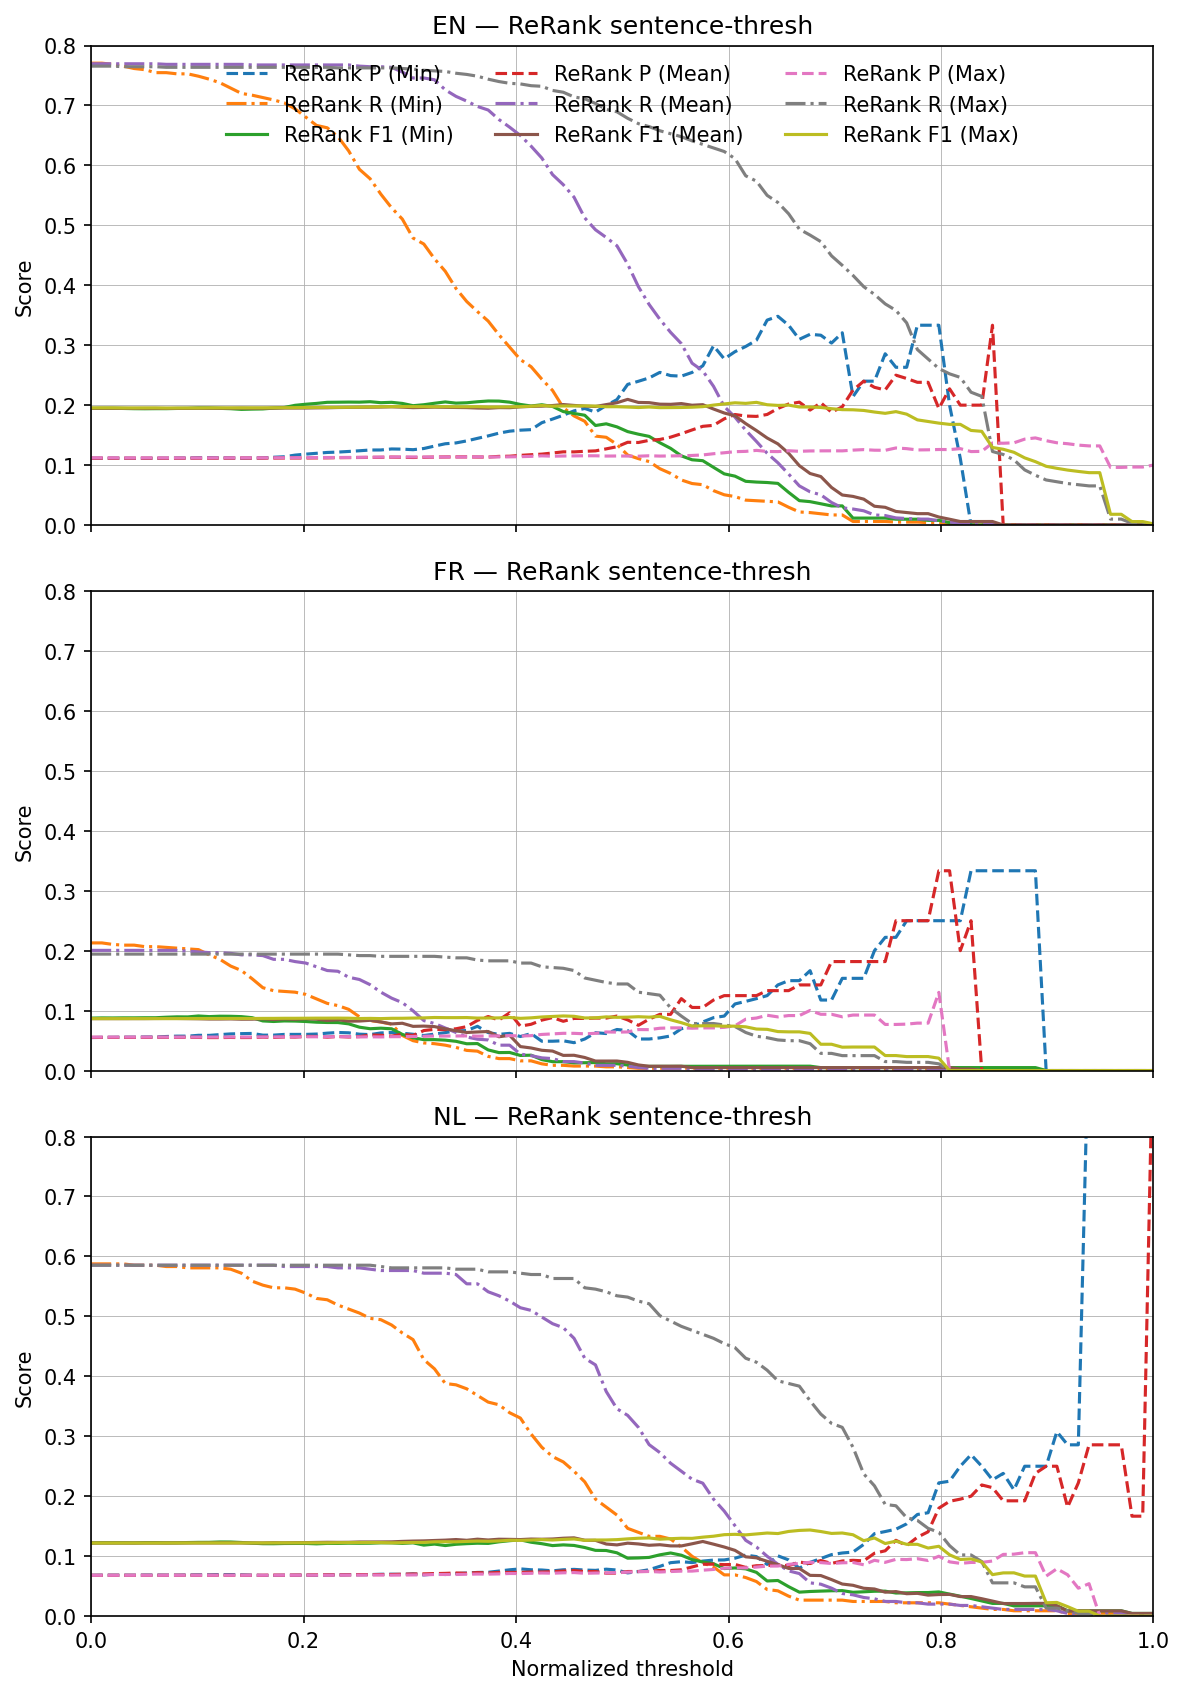

In [13]:
# # Cell 3: ReRank Sentence-Thresholding (Min / Mean / Max)
# import numpy as np
# import matplotlib.pyplot as plt
# from pathlib import Path
# from collections import defaultdict
# from extractomat.tester import TermEvaluator

# langs = list(rerank_results.keys())
# split = "val"

# fig, axes = plt.subplots(len(langs), 1, figsize=(8, 4*len(langs)), sharex=True, sharey=True, dpi=150)

# for i, lang in enumerate(langs):
#     ax = axes[i]
#     rr_scores = rerank_results[lang][split]
#     term_occ  = c_value_results[lang][split]["term_occ"]
#     gt_csv = Path(language_output_dirs[lang][split]).with_suffix("").joinpath("gt_labels.csv")

#     for agg_name, func in [("Min", min), ("Mean", np.mean), ("Max", max)]:
#         # bucket per sentence
#         bucket = defaultdict(list)
#         for term, spans in term_occ.items():
#             sc = rr_scores.get(term, 0)
#             for sp in spans:
#                 bucket[sp.sent].append(sc)
#         vals = np.array([func(vs) for vs in bucket.values()])
#         thr = np.linspace(vals.min(), vals.max(), 100)
#         nt = (thr - thr.min())/(thr.max()-thr.min())

#         P = np.zeros_like(thr); R = np.zeros_like(thr); F = np.zeros_like(thr)
#         for j, t in enumerate(thr):
#             keep = {s for s, vs in bucket.items() if func(vs)>=t}
#             pr_occ = {term:[sp for sp in term_occ[term] if sp.sent in keep] for term in term_occ}
#             pr_sc = {term: rr_scores[term] for term, spans in pr_occ.items() if spans}
#             ev = TermEvaluator(gt_csv, pr_sc, pr_occ, method="rerank", language=lang)
#             try: P[j], R[j], F[j] = ev.calculate_metrics(thr[0]-1e-9)
#             except ZeroDivisionError: pass

#         ax.plot(nt, P, '--', label=f"ReRank P ({agg_name})")
#         ax.plot(nt, R, '-.', label=f"ReRank R ({agg_name})")
#         ax.plot(nt, F, '-', label=f"ReRank F1 ({agg_name})")

#     ax.set_xlim(0,1); ax.set_ylim(0,0.8)
#     ax.set_title(f"{lang.upper()} — ReRank sentence‐thresh")
#     ax.set_ylabel("Score"); ax.grid(True, lw=0.4)
#     if i==len(langs)-1: ax.set_xlabel("Normalized threshold")

# axes[0].legend(loc="upper center", ncol=3, frameon=False)
# plt.tight_layout(rect=[0,0,1,0.95])
# plt.show()


In [14]:
# import pandas as pd
# from pathlib import Path
# from tqdm.auto import tqdm

# # reuse sent2spans_map and best_thresholds from previous cell
# # stats collection list
# stats = []

# for lang, splits in sent2spans_map.items():
#     for split, sent2spans in splits.items():
#         thr = best_thresholds[lang][split]
#         out_dir = Path("/content/drive/MyDrive/ucu/ner/threshold_datasets") / lang
#         out_dir.mkdir(exist_ok=True)
#         fname = f"rerank_{thr:.3f}_{split}.tsv"
#         out_path = out_dir / fname
#         out_path.unlink(missing_ok=True)

#         b_cnt = i_cnt = o_cnt = sent_cnt = 0
#         with out_path.open("w", encoding="utf-8") as fout:
#             for sent, spans in tqdm(sent2spans.items(), desc=f"Writing {lang}-{split}", unit="sent"):
#                 if max(sc for _, sc in spans) < thr:
#                     continue

#                 labels = ["O"] * len(sent)
#                 for span, sc in spans:
#                     if sc < thr:
#                         continue
#                     start = span.start - sent.start
#                     end   = span.end   - sent.start
#                     labels[start] = "B-TERM"
#                     for k in range(start+1, min(end, len(labels))):
#                         labels[k] = "I-TERM"

#                 for tok, lbl in zip(sent, labels):
#                     if lbl == "O":
#                         o_cnt += 1
#                     elif lbl == "B-TERM":
#                         b_cnt += 1
#                     else:
#                         i_cnt += 1
#                     fout.write(f"{tok.text}\t{lbl}\n")
#                 fout.write("\n")
#                 sent_cnt += 1

#         stats.append({
#             'language': lang,
#             'split': split,
#             'method': 'ReRank',
#             'aggregation': 'max',
#             'threshold': thr,
#             '#sentences': sent_cnt,
#             '#entities': b_cnt + i_cnt,
#             '#b': b_cnt,
#             '#i': i_cnt,
#             '#o': o_cnt
#         })
#         print(f"Wrote {out_path}: sentences={sent_cnt}, B={b_cnt}, I={i_cnt}, O={o_cnt}")

# # display summary
# df = pd.DataFrame(stats, columns=['language','split','method','aggregation','threshold',
#                                   '#sentences','#entities','#b','#i','#o'])
# from IPython.display import display
# display(df)


NameError: name 'sent2spans_map' is not defined

In [ ]:
# import sys, os
# from pathlib import Path
# import numpy as np
# import matplotlib.pyplot as plt
# from extractomat.sbert_reranker import SentenceSimilarityCalculator

# # ── load torch & SBERT (GPU if available) ─────────────────────────────────
# import torch
# from sentence_transformers import SentenceTransformer  # imported for completeness

# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"🔧 SBERT device → {device}")

# # ── instantiate the reranker correctly ────────────────────────────────────
# reranker = SentenceSimilarityCalculator(
#     model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
#     device=device
# )

# # ── re-rank your C-Value candidates ───────────────────────────────────────
# reranked_scores = reranker.rerank_terms_in_doc(
#     doc,             # spaCy Doc from C-Value step
#     term_occ,        # occurrences dict from C-Value step
#     context_len=3,
#     pooling="max"
# )
# print(f"✅ Re-ranked {len(reranked_scores):,} terms")

In [ ]:
# for language in languages:
#     for subset in c_value_results[language].keys():
#         gt_csv = Path(os.path.join(Path(language_output_dirs[language][subset]).with_suffix(""), "gt_labels.csv"))
#         term_scores = c_value_results[language][subset]["term_scores"]
#         term_occ = c_value_results[language][subset]["term_occ"]

#         evaluator = TermEvaluator(
#             gt_csv,
#             term_scores,
#             term_occ,
#             method="cvalue",
#             language=language
#         )

#         scores = np.array(list(term_scores.values()))
#         t_min, t_max = scores.min(), scores.max()
#         thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

#         best = {"f1": -1.0}

#         for t in thresholds:
#             try:
#                 p, r, f1 = evaluator.calculate_metrics(t)
#             except ZeroDivisionError:
#                 # no candidates or no GT terms at this t → skip
#                 continue
#             if f1 > best["f1"]:
#                 best.update(threshold=t, precision=p, recall=r, f1=f1)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import importlib.util
# from pathlib import Path

# # original score range
# scores = np.array(list(term_scores.values()))
# t_min, t_max = scores.min(), scores.max()

# # generate absolute thresholds, then normalize
# abs_thresholds = np.linspace(t_min - 1e-9, t_max, num=100)
# norm_thresholds = (abs_thresholds - t_min) / (t_max - t_min)

# precisions, recalls, f1_scores = [], [], []
# for t in abs_thresholds:
#     try:
#         p, r, f1 = evaluator.calculate_metrics(t)
#     except ZeroDivisionError:
#         p = r = f1 = 0.0
#     precisions.append(p)
#     recalls.append(r)
#     f1_scores.append(f1)

# # convert to arrays
# precisions = np.array(precisions)
# recalls    = np.array(recalls)
# f1_scores  = np.array(f1_scores)

# # find best F1 index
# best_idx = np.argmax(f1_scores)
# best = {
#     'threshold_norm': norm_thresholds[best_idx],
#     'precision':     precisions[best_idx],
#     'recall':        recalls[best_idx],
#     'f1':            f1_scores[best_idx]
# }

# # ── plotting ──────────────────────────────────────────────────────────────
# plt.figure(figsize=(12, 8), dpi=150)
# plt.plot(norm_thresholds, precisions, label="Precision")
# plt.plot(norm_thresholds, recalls,    label="Recall")
# plt.plot(norm_thresholds, f1_scores,  label="F1 Score")
# plt.xlabel("Normalized Threshold (0–1)")
# plt.ylabel("Score")
# plt.title("C-Value: Precision, Recall & F1 vs Normalized Threshold\nfor ACTER English (C-Value vs Gold IOB Terms)")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

# # ── best result ────────────────────────────────────────────────────────────
# print("▶ Best C-Value results (threshold sweep):")
# print(f"   threshold = {best['threshold_norm']:.5f}")
# print(f"   precision = {best['precision']:.3f}")
# print(f"   recall    = {best['recall']:.3f}")
# print(f"   F1        = {best['f1']:.3f}")


In [ ]:
# (1.16507 - t_min) / (t_max - t_min)

In [ ]:
# # prompt: generate a min max scaling for treshold based on t_min and t_max

# import matplotlib.pyplot as plt
# scaled_thresholds = (thresholds - t_min) / (t_max - t_min)

# # You can now use `scaled_thresholds` for plotting or further analysis
# plt.figure(figsize=(12, 8), dpi=150)
# plt.plot(scaled_thresholds, precisions, label="Precision")
# plt.plot(scaled_thresholds, recalls,    label="Recall")
# plt.plot(scaled_thresholds, f1_scores,  label="F1 Score")
# plt.xlabel("Scaled Threshold")
# plt.ylabel("Score")
# plt.title("C-Value: Precision, Recall & F1 vs Scaled Threshold\nfor ACTER English (C-Value vs Gold IOB Terms)")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# import sys, os
# from pathlib import Path
# import numpy as np
# import matplotlib.pyplot as plt
# from extractomat.sbert_reranker import SentenceSimilarityCalculator

# # ── load torch & SBERT (GPU if available) ─────────────────────────────────
# import torch
# from sentence_transformers import SentenceTransformer  # imported for completeness

# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"🔧 SBERT device → {device}")

# # ── instantiate the reranker correctly ────────────────────────────────────
# reranker = SentenceSimilarityCalculator(
#     model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
#     device=device
# )

# # ── re-rank your C-Value candidates ───────────────────────────────────────
# reranked_scores = reranker.rerank_terms_in_doc(
#     doc,             # spaCy Doc from C-Value step
#     term_occ,        # occurrences dict from C-Value step
#     context_len=3,
#     pooling="max"
# )
# print(f"✅ Re-ranked {len(reranked_scores):,} terms")

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# r_scores = np.array(list(reranked_scores.values()))
# t_min, t_max = r_scores.min(), r_scores.max()
# thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

# precisions, recalls, f1_scores = [], [], []
# for t in thresholds:
#     try:
#         p, r, f1 = evaluator.calculate_metrics(t)
#     except ZeroDivisionError:
#         p = r = f1 = 0.0
#     precisions.append(p)
#     recalls.append(r)
#     f1_scores.append(f1)

# # convert to numpy arrays for easy indexing
# precisions = np.array(precisions)
# recalls    = np.array(recalls)
# f1_scores  = np.array(f1_scores)

# # find the index of the best F1 score
# best_idx = np.argmax(f1_scores)

# # print best-results block
# print("Best ReRank results (threshold sweep):")
# print(f"   threshold = {thresholds[best_idx]:.5f}")
# print(f"   precision = {precisions[best_idx]:.3f}")
# print(f"   recall    = {recalls[best_idx]:.3f}")
# print(f"   F1        = {f1_scores[best_idx]:.3f}")

# # ── plotting ──────────────────────────────────────────────────────────────
# plt.figure(figsize=(12, 8), dpi=150)
# plt.plot(thresholds, precisions, label="Precision")
# plt.plot(thresholds, recalls,    label="Recall")
# plt.plot(thresholds, f1_scores,  label="F1 Score")
# plt.xlabel("Threshold")
# plt.ylabel("Score")
# plt.title("ReRank: Precision, Recall & F1 vs Threshold\nfor ACTER English (ReRank vs Gold IOB Terms)")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import importlib.util
# from pathlib import Path

# r_scores = np.array(list(reranked_scores.values()))
# t_min, t_max = r_scores.min(), r_scores.max()
# thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

# precisions, recalls, f1_scores = [], [], []
# for t in thresholds:
#     try:
#         p, r, f1 = evaluator.calculate_metrics(t)
#     except ZeroDivisionError:
#         p = r = f1 = 0.0
#     precisions.append(p)
#     recalls.append(r)
#     f1_scores.append(f1)

# # ── plotting ──────────────────────────────────────────────────────────────
# plt.figure(figsize=(12, 8), dpi=150)
# plt.plot(thresholds, precisions, label="Precision")
# plt.plot(thresholds, recalls,    label="Recall")
# plt.plot(thresholds, f1_scores,  label="F1 Score")
# plt.xlabel("Threshold")
# plt.ylabel("Score")
# plt.title("C-Value: Precision, Recall & F1 vs Threshold\nfor ACTER English (ReRank vs Gold IOB Terms)")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()



In [ ]:


# # ── rebuild gold terms from IOB validation split (val_full.tsv) ──────────
# val_tsv = Path("val_full.tsv")
# gold_terms = set()
# current = []

# for line in val_tsv.read_text(encoding="utf-8").splitlines():
#     if not line.strip():
#         if current:
#             gold_terms.add(" ".join(current).lower())
#             current = []
#         continue
#     token, label = line.split("\t")
#     if label.startswith("B"):
#         if current:
#             gold_terms.add(" ".join(current).lower())
#         current = [token]
#     elif label.startswith("I") and current:
#         current.append(token)
#     else:
#         if current:
#             gold_terms.add(" ".join(current).lower())
#             current = []
# if current:
#     gold_terms.add(" ".join(current).lower())

# print(f"🎯 Loaded {len(gold_terms):,} gold terms")

In [ ]:
# scores = np.array(list(reranked_scores.values()))
# t_min, t_max = scores.min(), scores.max()
# thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

# precisions, recalls, f1_scores = [], [], []
# for t in thresholds:
#     preds = {term for term, sc in reranked_scores.items() if sc >= t}
#     tp = len(preds & gold_terms)
#     p = tp / len(preds) if preds else 0.0
#     r = tp / len(gold_terms) if gold_terms else 0.0
#     f1 = (2 * p * r / (p + r)) if (p + r) > 0 else 0.0
#     precisions.append(p)
#     recalls.append(r)
#     f1_scores.append(f1)

# # ── plot Precision, Recall & F1 vs Threshold ─────────────────────────────
# plt.figure(figsize=(12, 8), dpi=150)
# plt.plot(thresholds, precisions, label="Precision")
# plt.plot(thresholds, recalls,    label="Recall")
# plt.plot(thresholds, f1_scores,  label="F1 Score")
# plt.xlabel("Threshold")
# plt.ylabel("Score")
# plt.title(
#     "SBERT ReRank: Precision, Recall & F1 vs Threshold\n"
#     "for ACTER English (ReRank vs Gold IOB Terms)"
# )
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()
# scores_arr = np.array(list(reranked_scores.values()))
# t_min, t_max = scores_arr.min(), scores_arr.max()
# thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

# best = {"f1": -1.0}
# for t in thresholds:
#     preds = {term for term, sc in reranked_scores.items() if sc >= t}
#     tp = len(preds & gold_terms)
#     p = tp / len(preds) if preds else 0.0
#     r = tp / len(gold_terms) if gold_terms else 0.0
#     f1 = (2 * p * r / (p + r)) if (p + r) > 0 else 0.0
#     if f1 > best["f1"]:
#         best.update(threshold=t, precision=p, recall=r, f1=f1)

# print("▶ Best ReRanked Results:")
# print(f"   threshold = {best['threshold']:.5f}")
# print(f"   precision = {best['precision']:.3f}")
# print(f"   recall    = {best['recall']:.3f}")
# print(f"   F1        = {best['f1']:.3f}")

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from collections import defaultdict

# # ---------------------------------------------------------------------------
# # This cell assumes term_scores, term_occ, and reranked_scores are already
# # defined from your earlier C‑Value and ReRank steps.
# # ---------------------------------------------------------------------------

# # 1) Bucket all scores that belong to each sentence
# bucket_c, bucket_r = defaultdict(list), defaultdict(list)

# for term, spans in term_occ.items():
#     c_val = term_scores[term]
#     r_val = reranked_scores.get(term, None)
#     for span in spans:
#         s = span.sent  # spaCy sentence object
#         bucket_c[s].append(c_val)
#         if r_val is not None:
#             bucket_r[s].append(r_val)

# # 2) Compute per‑sentence min / mean / max
# def per_sentence_stats(bucket):
#     mins, means, maxs = [], [], []
#     for scores in bucket.values():
#         mins.append(min(scores))
#         means.append(np.mean(scores))
#         maxs.append(max(scores))
#     return np.array(mins), np.array(means), np.array(maxs)

# c_min, c_mean, c_max = per_sentence_stats(bucket_c)
# r_min, r_mean, r_max = per_sentence_stats(bucket_r)

# stat_arrays = {
#     "C-Value": {"min": c_min, "mean": c_mean, "max": c_max},
#     "ReRank":  {"min": r_min, "mean": r_mean, "max": r_max}
# }

# # 3) Threshold ranges (use overall min/max of each method)
# thr_c = np.linspace(c_min.min(), c_max.max(), 100)
# thr_r = np.linspace(r_min.min(), r_max.max(), 100)

# # 4) Compute sentence counts (not rates) above each threshold
# cnt_c = {stat: [int((arr > t).sum()) for t in thr_c]
#          for stat, arr in stat_arrays["C-Value"].items()}
# cnt_r = {stat: [int((arr > t).sum()) for t in thr_r]
#          for stat, arr in stat_arrays["ReRank"].items()}

# # 5) Plot: #sentences retained vs threshold
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=120)

# for stat in ["min", "mean", "max"]:
#     ax1.plot(thr_c, cnt_c[stat], label=f"{stat.capitalize()}")
#     ax2.plot(thr_r, cnt_r[stat], label=f"{stat.capitalize()}")

# ax1.set_title("C‑Value: sentences retained vs threshold")
# ax1.set_xlabel("Threshold"); ax1.set_ylabel("# Sentences")
# ax1.grid(True); ax1.legend()

# ax2.set_title("ReRank: sentences retained vs threshold")
# ax2.set_xlabel("Threshold"); ax2.set_ylabel("# Sentences")
# ax2.grid(True); ax2.legend()

# plt.tight_layout(); plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from collections import defaultdict

# # Cell 7 – Compute per-sentence confidence and plot retention vs threshold

# # Choose scores: prefer reranked_scores if available, else fallback to term_scores
# scores_dict = globals().get('reranked_scores') or globals().get('term_scores')
# occ_dict = globals().get('term_occ')

# # Sanity check
# assert scores_dict is not None and occ_dict is not None, \
#     "Error: term_scores/term_occ or reranked_scores/term_occ not found in memory."

# # Map each sentence to the list of term scores within it
# sent_scores = defaultdict(list)
# for term, spans in occ_dict.items():
#     score = scores_dict[term]
#     for span in spans:
#         sent = span.sent  # spaCy Span.sent property gives the sentence
#         sent_scores[sent].append(score)

# # Compute confidence per sentence as the max score of its term predictions
# sent_conf = {sent: max(scores) for sent, scores in sent_scores.items()}

# # Prepare retention data for threshold sweep
# conf_values = np.array(list(sent_conf.values()))
# t_min, t_max = conf_values.min(), conf_values.max()
# thresholds = np.linspace(t_min - 1e-9, t_max, num=50)
# retentions = [sum(1 for c in conf_values if c >= t) for t in thresholds]

# # Plot retention curve
# plt.figure(figsize=(12, 8), dpi=150)
# plt.plot(thresholds, retentions)
# plt.xlabel("Confidence Threshold")
# plt.ylabel("Number of Sentences Retained")
# plt.title("Retention Curve: Sentences Retained vs Confidence Threshold")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Display a few example sentences above the median confidence
# median_conf = np.median(conf_values)
# kept = [sent for sent, c in sent_conf.items() if c >= median_conf]
# print(f"Sample sentences with confidence ≥ {median_conf:.3f}:")
# for sent in kept[:5]:
#     print(" -", sent.text)


In [ ]:
# # Compute sentence-level confidences for both methods
# sent_scores_c = defaultdict(list)
# sent_scores_r = defaultdict(list)
# for term, spans in term_occ.items():
#     score_c = term_scores[term]
#     score_r = reranked_scores[term]
#     for span in spans:
#         sent = span.sent
#         sent_scores_c[sent].append(score_c)
#         sent_scores_r[sent].append(score_r)
# sent_conf_c = {s: max(lst) for s, lst in sent_scores_c.items()}
# sent_conf_r = {s: max(lst) for s, lst in sent_scores_r.items()}

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Build thresholds over the union of both domains
# all_confs = np.concatenate([list(sent_conf_c.values()), list(sent_conf_r.values())])
# t_min, t_max = all_confs.min(), all_confs.max()
# thresholds = np.linspace(t_min, t_max, num=5000)

# ret_c = [(np.sum(list(sent_conf_c.values()) >= t)) for t in thresholds]
# ret_r = [(np.sum(list(sent_conf_r.values()) >= t)) for t in thresholds]


# plt.figure(figsize=(10, 6), dpi=120)
# plt.xlim(0, 25)
# plt.plot(thresholds, ret_c, label="C-Value retention")
# plt.plot(thresholds, ret_r, label="ReRank retention")
# plt.xlabel("Confidence Threshold")
# plt.ylabel("Sentences Retained")
# plt.title("Sentence Retention vs Threshold\nC-Value vs ReRank")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Assumes sent_conf_c, sent_conf_r, and doc are already in memory
# assert 'sent_conf_c' in globals() and 'sent_conf_r' in globals(), "Run the confidence computation cell first"
# assert 'doc' in globals(), "Run the C-Value extraction cell to define `doc`"

# # Fixed thresholds for each method
# threshold_c = 2.25  # C-Value cutoff
# threshold_r = 0.4  # ReRank cutoff

# # Build fine-grained thresholds over observed confidence ranges
# all_confs = np.concatenate([list(sent_conf_c.values()), list(sent_conf_r.values())])
# t_min, t_max = all_confs.min(), all_confs.max()
# thresholds = np.linspace(t_min, t_max, num=5000)

# # Compute retention counts at each threshold
# ret_c = np.array([np.sum(np.array(list(sent_conf_c.values())) >= t) for t in thresholds])
# ret_r = np.array([np.sum(np.array(list(sent_conf_r.values())) >= t) for t in thresholds])

# # Plot retention curves
# plt.figure(figsize=(12, 8), dpi=150)
# plt.plot(thresholds, ret_c, label="C-Value retention")
# plt.plot(thresholds, ret_r, label="ReRank retention")

# # Limit x-axis and add vertical threshold lines
# plt.xlim(0, 25)
# plt.axvline(threshold_c, color='pink', linestyle='--', label=f"C-Value threshold = {threshold_c}")
# plt.axvline(threshold_r, color='red', linestyle='--', label=f"ReRank threshold = {threshold_r}")

# plt.xlabel("Confidence Threshold")
# plt.ylabel("Sentences Retained")
# plt.title("Sentence Retention vs Threshold\nC-Value vs ReRank")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Calculate and print percentages of sentences retained
# total_sents = len(list(doc.sents))
# retained_c = np.sum(np.array(list(sent_conf_c.values())) >= threshold_c)
# retained_r = np.sum(np.array(list(sent_conf_r.values())) >= threshold_r)
# pct_c = retained_c / total_sents * 100
# pct_r = retained_r / total_sents * 100

# print(f"C-Value threshold {threshold_c}: retained {retained_c}/{total_sents} sentences ({pct_c:.2f}%)")
# print(f"ReRank threshold {threshold_r}: retained {retained_r}/{total_sents} sentences ({pct_r:.2f}%)")


In [ ]:
# from pathlib import Path
# from collections import defaultdict
# from tqdm.auto import tqdm
# import sys, os

# # ── ensure extractomat is importable ───────────────────────────────────────
# sys.path.insert(0, os.path.join(os.getcwd(), "extractomat"))

# # ── preconditions ─────────────────────────────────────────────────────────
# assert 'doc' in globals(), "Please re-run C-Value extraction to define `doc`."
# assert 'term_occ' in globals(), "Please re-run C-Value extraction to define `term_occ`."
# assert 'term_scores' in globals(), "Please re-run C-Value extraction to define `term_scores`."
# assert 'reranked_scores' in globals(), "Please re-run SBERT ReRank to define `reranked_scores`."

# # ── map sentences to their spans with scores ──────────────────────────────
# sent2spans = defaultdict(list)
# for term, spans in term_occ.items():
#     sc = term_scores[term]
#     sr = reranked_scores[term]
#     for span in spans:
#         # find parent sentence by boundaries
#         for sent in doc.sents:
#             if span.start >= sent.start and span.end <= sent.end:
#                 sent2spans[sent].append((span, sc, sr))
#                 break

# # ── prepare sentences ───────────────────────────────────────────────────────
# sentences = list(doc.sents)

# # ── define splits and their inclusion functions ────────────────────────────
# splits = {
#     "train_cvalue_original.tsv":       lambda spans: True,
#     f"train_cvalue_conf{threshold_c}.tsv": lambda spans: max((sc for _, sc, _ in spans), default=0) >= threshold_c,
#     "train_rerank_original.tsv":       lambda spans: True,
#     f"train_rerank_conf{threshold_r}.tsv": lambda spans: max((sr for _, _, sr in spans), default=0) >= threshold_r,
# }

# # ── output directory ───────────────────────────────────────────────────────
# output_dir = Path("/content/drive/MyDrive/ucu/ner/datasets")
# output_dir.mkdir(exist_ok=True)


# # ── generate each file with stats logging ─────────────────────────────────
# for fname, keep_fn in splits.items():
#     out_path = output_dir / fname
#     b_count = i_count = o_count = blank_count = 0
#     with out_path.open("w", encoding="utf-8") as fout:
#         for sent in tqdm(sentences, desc=f"Writing {fname}", unit="sent"):
#             spans = sent2spans.get(sent, [])
#             if not keep_fn(spans):
#                 continue

#             # initialize labels
#             labels = ["O"] * len(sent)
#             # assign B/I labels for spans above threshold
#             for span, sc, sr in spans:
#                 score = sc if "cvalue" in fname else sr
#                 thresh = threshold_c if "cvalue" in fname else threshold_r
#                 if score < thresh:
#                     continue
#                 start = span.start - sent.start
#                 end   = span.end   - sent.start
#                 labels[start] = "B"
#                 for j in range(start+1, end):
#                     labels[j] = "I"

#             # write tokens and count labels
#             for token, lbl in zip(sent, labels):
#                 if lbl == "O":
#                     o_count += 1
#                     fout.write(f"{token.text}\tO\n")
#                 else:
#                     if lbl == "B":
#                         b_count += 1
#                         fout.write(f"{token.text}\tB-TERM\n")
#                     else:
#                         i_count += 1
#                         fout.write(f"{token.text}\tI-TERM\n")
#             # end of sentence
#             fout.write("\n")
#             blank_count += 1

#     print(f"✓ Wrote {out_path.name}")
#     print(f"  → Sentences (blanks): {blank_count}")
#     print(f"  → B-TERM tokens:     {b_count}")
#     print(f"  → I-TERM tokens:     {i_count}")
#     print(f"  → O tokens:          {o_count}\n")


In [ ]:
# from google.colab import runtime
# runtime.unassign()